# Analysis of Sjogrens Syndrome PBMCs

## Data source: GSE157278

### **Single-cell RNA Sequencing reveals the expansion of Cytotoxic CD4+ T lymphocytes and the heterogeneity of pathogenesis in primary Sjögren’s syndrome patients**

#### "By single cell RNA sequencing, our data revealed disease-specific immune cell subsets and provide some potential new targets of pSS, specific expansion of CD4+ CTLs may be involved in the pathogenesis of pSS, which might give a valuable insights for therapeutic interventions of pSS."

#### "We applied single cell RNA sequencing (scRNA-seq) to 57, 288 peripheral blood mononuclear cells (PBMCs) from 5 patients with pSS and 5 healthy controls. The immune cell subsets and susceptibility genes involved in the pathogenesis of pSS were analyzed."

In [1]:
PDIR = '/Users/aumchampaneri/VSCode Projects/complement-receptor-blockade/'

# Convert raw data to AnnData

In [2]:
import os
import scanpy as sc

# Path to the folder containing your raw-data files
data_dir = f"{PDIR}/sjogrens-pbmc/raw-data"
print("Files in directory:", os.listdir(data_dir))

# Read 10x Genomics formatted data
adata = sc.read_10x_mtx(
    data_dir,             # Path to directory with matrix.mtx, barcodes.tsv, features.tsv
    var_names='gene_symbols',  # Use gene symbols for variable names
    cache=True,                 # Cache the result for faster future loading
)

Files in directory: ['cell_batch.tsv.gz', 'features.tsv.gz', 'barcodes.tsv.gz', 'matrix.mtx.gz']


In [3]:
# Set .raw attribute to preserve raw counts for downstream pseudobulk/DESeq2
adata.raw = adata.copy()
print('Set adata.raw. Shape:', adata.raw.shape)


Set adata.raw. Shape: (61405, 33694)


In [4]:
# Unpack cell_batch.tsv.gz if it exists and append to adata.obs
import pandas as pd
import gzip
import shutil

cell_batch_path = os.path.join(data_dir, 'cell_batch.tsv.gz')
if os.path.exists(cell_batch_path):
    with gzip.open(cell_batch_path, 'rt') as f_in:
        with open('cell_batch.tsv', 'w') as f_out:
            shutil.copyfileobj(f_in, f_out)
    cell_batch_df = pd.read_csv('cell_batch.tsv', sep='\t', index_col=0)
    adata.obs = adata.obs.join(cell_batch_df)
    os.remove('cell_batch.tsv')  # Clean up the unzipped file
    print("Appended cell batch information to adata.obs")

# Print basic information about the AnnData object
print(adata)

Appended cell batch information to adata.obs
AnnData object with n_obs × n_vars = 61405 × 33694
    obs: 'batch'
    var: 'gene_ids', 'feature_types'


## Data exploration

In [5]:
adata

AnnData object with n_obs × n_vars = 61405 × 33694
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

In [6]:
adata.obs

batch
AAACCTGAGACCTAGG-1    HC-1
AAACCTGAGCCACCTG-1    HC-1
AAACCTGAGTCATCCA-1    HC-1
AAACCTGCAGATGAGC-1    HC-1
AAACCTGCATCCGCGA-1    HC-1
...                    ...
TTTGTCAGTCTAGTGT-10  pSS-5
TTTGTCAGTCTCTCTG-10  pSS-5
TTTGTCAGTGCACGAA-10  pSS-5
TTTGTCAGTGCAGGTA-10  pSS-5
TTTGTCAGTTACGCGC-10  pSS-5

[61405 rows x 1 columns]

In [7]:
adata.var

gene_ids    feature_types
RP11-34P13.3  ENSG00000243485  Gene Expression
FAM138A       ENSG00000237613  Gene Expression
OR4F5         ENSG00000186092  Gene Expression
RP11-34P13.7  ENSG00000238009  Gene Expression
RP11-34P13.8  ENSG00000239945  Gene Expression
...                       ...              ...
AC233755.2    ENSG00000277856  Gene Expression
AC233755.1    ENSG00000275063  Gene Expression
AC240274.1    ENSG00000271254  Gene Expression
AC213203.1    ENSG00000277475  Gene Expression
FAM231B       ENSG00000268674  Gene Expression

[33694 rows x 2 columns]

## Data modification

1. Merge 'cell_batch.tsv' to .obs layer
2. Extrapolate 'disease' and patient_ID
3. Rearange and rename .var columns

In [8]:
import pandas as pd

# Read the cell_batch file, using the first column (barcodes) as the index
cell_batch = pd.read_csv(f"{PDIR}/sjogrens-pbmc/raw-data/cell_batch.tsv.gz", sep='\t', header=0, index_col=0)

# Align and assign the batch/condition info to AnnData obs
adata.obs['cell_batch'] = adata.obs_names.map(cell_batch.iloc[:, 0])

# Preview the result
print(adata.obs[['cell_batch']].head())

                   cell_batch
AAACCTGAGACCTAGG-1       HC-1
AAACCTGAGCCACCTG-1       HC-1
AAACCTGAGTCATCCA-1       HC-1
AAACCTGCAGATGAGC-1       HC-1
AAACCTGCATCCGCGA-1       HC-1


In [9]:
# Duplicate barcodes index into a new column
adata.obs['barcodes'] = adata.obs.index
print("adata.obs columns after adding barcodes:", adata.obs.columns)
print(adata.obs.head())

adata.obs columns after adding barcodes: Index(['batch', 'cell_batch', 'barcodes'], dtype='object')
                   batch cell_batch            barcodes
AAACCTGAGACCTAGG-1  HC-1       HC-1  AAACCTGAGACCTAGG-1
AAACCTGAGCCACCTG-1  HC-1       HC-1  AAACCTGAGCCACCTG-1
AAACCTGAGTCATCCA-1  HC-1       HC-1  AAACCTGAGTCATCCA-1
AAACCTGCAGATGAGC-1  HC-1       HC-1  AAACCTGCAGATGAGC-1
AAACCTGCATCCGCGA-1  HC-1       HC-1  AAACCTGCATCCGCGA-1


In [10]:
# Extract disease and patient id from the cell_batch column
disease_labels = adata.obs['cell_batch'].str.extract(r'^(pSS|HC)')[0]
patient_ids = adata.obs['cell_batch'].str.extract(r'-(\d+)$')[0]

# Assign disease column
adata.obs['disease'] = disease_labels

# Set HC in disease column to 'normal'
adata.obs.loc[adata.obs['disease'] == 'HC', 'disease'] = 'normal'

# Set pSS in disease column to 'sjogren syndrome'
adata.obs.loc[adata.obs['disease'] == 'pSS', 'disease'] = 'sjogren syndrome'

# Create a mapping from (disease, patient_id) to a unique join_id number (1-10)
unique_patients = adata.obs[['disease', 'cell_batch']].drop_duplicates()
unique_patients['join_id'] = range(1, len(unique_patients) + 1)

# Merge back to obs to assign patient numbers
adata.obs = adata.obs.merge(unique_patients[['cell_batch', 'join_id']], left_on='cell_batch', right_on='cell_batch', how='left')

# Add count data
adata.obs["n_counts"] = adata.X.sum(axis=1)

# Assign batch to cell_batch for pseudobulk aggregation
adata.obs["batch"] = adata.obs["cell_batch"]

# Preview the new columns
print(adata.obs[['cell_batch', 'disease', 'join_id', 'batch']].head())

  cell_batch disease  join_id batch
0       HC-1  normal        1  HC-1
1       HC-1  normal        1  HC-1
2       HC-1  normal        1  HC-1
3       HC-1  normal        1  HC-1
4       HC-1  normal        1  HC-1


In [11]:
# Duplicate the .var index to a new column 'feature_names'
adata.var["feature_names"] = adata.var.index

# Rename gene_ids to ensembl_id
adata.var.rename(columns={"gene_ids": "ensembl_id"}, inplace=True)

# Replace the information in the index column with the ensembl_id values
adata.var.index = adata.var["ensembl_id"]

# Clear the index column name
adata.var.index.name = None

## Save processed AnnData object

In [12]:
import os
os.makedirs(f"{PDIR}/sjogrens-pbmc/input-data/", exist_ok=True)

In [13]:
# Save prepared AnnData object for Geneformer tokenization
adata.write_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_prepared.h5ad")

# Data processing (Quality Control)

1. Load adata
2. scanpy zheng17 recipe
3. UMAP
4. Save adata

In [14]:
import scanpy as sc

adata = sc.read_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_prepared.h5ad")

/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Use scanpy for processing (zheng17 recipe)

/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scanpy/preprocessing/_recipes.py:185: FutureWarning: Use sc.pp.highly_variable_genes instead
  filter_result = filter_genes_dispersion(
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scanpy/preprocessing/_recipes.py:191: FutureWarning: Use sc.pl.highly_variable_genes instead
  ppp.filter_genes_dispersion(filter_result, log=True)


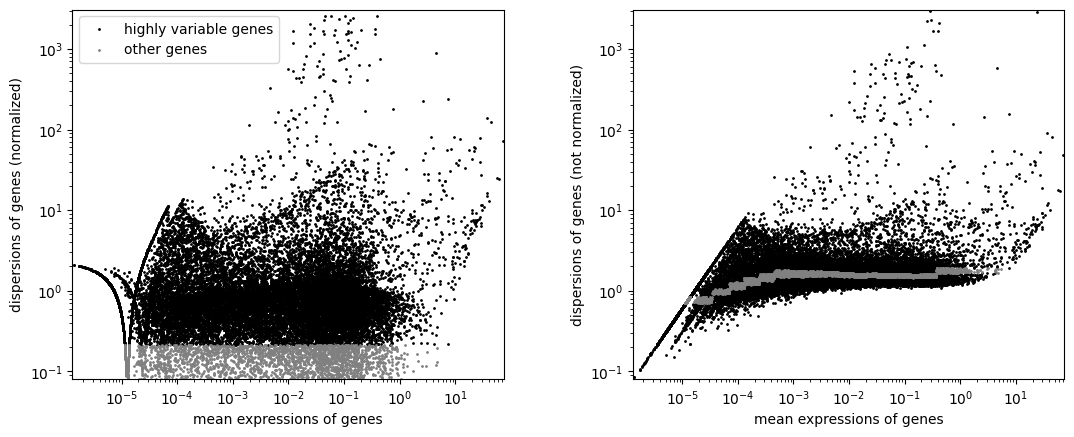

/Users/aumchampaneri/.pyenv/versions/3.10.18/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [15]:
sc.pp.recipe_zheng17(
    adata,
    n_top_genes=20000,
    log = True,
    plot=True,
    copy=False
)

## Harmony batch correction (WIP)

In [16]:
print("Running Harmony batch correction...")
import scanpy.external as sce
import numpy as np

# PCA
sc.pp.pca(adata, n_comps=50, svd_solver='arpack')

print("Harmony will use 'batch' column for integration. Unique batch values:", adata.obs["batch"].unique())
sce.pp.harmony_integrate(adata, "batch")

Running Harmony batch correction...


2026-02-09 16:43:39,695 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Harmony will use 'batch' column for integration. Unique batch values: ['HC-1', 'HC-2', 'HC-3', 'HC-4', 'HC-5', 'pSS-1', 'pSS-2', 'pSS-3', 'pSS-4', 'pSS-5']
Categories (10, object): ['HC-1', 'HC-2', 'HC-3', 'HC-4', ..., 'pSS-2', 'pSS-3', 'pSS-4', 'pSS-5']


2026-02-09 16:43:46,445 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-02-09 16:43:46,568 - harmonypy - INFO - Iteration 1 of 10
2026-02-09 16:43:57,017 - harmonypy - INFO - Iteration 2 of 10
2026-02-09 16:44:07,798 - harmonypy - INFO - Iteration 3 of 10
2026-02-09 16:44:18,790 - harmonypy - INFO - Iteration 4 of 10
2026-02-09 16:44:29,532 - harmonypy - INFO - Iteration 5 of 10
2026-02-09 16:44:37,464 - harmonypy - INFO - Iteration 6 of 10
2026-02-09 16:44:42,490 - harmonypy - INFO - Iteration 7 of 10
2026-02-09 16:44:47,703 - harmonypy - INFO - Iteration 8 of 10
2026-02-09 16:44:52,549 - harmonypy - INFO - Iteration 9 of 10
2026-02-09 16:44:57,135 - harmonypy - INFO - Converged after 9 iterations


## Plot UMAP

/var/folders/p2/rh6xbt2n0nj6rn3qqpc7s1_m0000gn/T/ipykernel_21774/3501351353.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


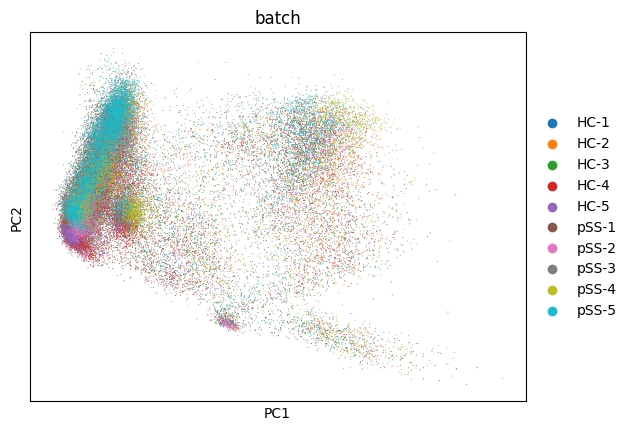

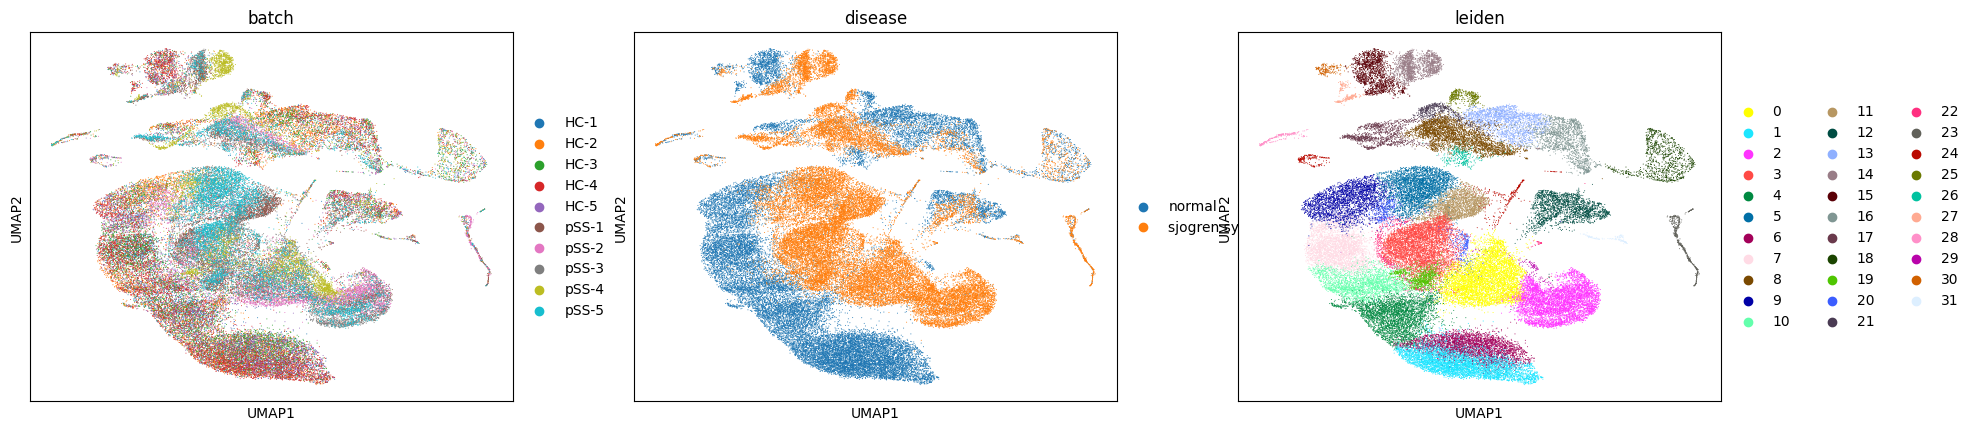

In [17]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata)

# Plots
sc.pl.pca(adata, color="batch")
sc.pl.umap(
    adata,
    color=["batch", "disease", "leiden"]
)

## Save processed AnnData object

In [18]:
adata.write_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_processed.h5ad")

# Cell type annotation - CellTypist

In [19]:
import scanpy as sc

adata = sc.read_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_prepared.h5ad")

/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Run CellTypist

In [20]:
import mygene
import numpy as np
import celltypist
from celltypist.models import Model
import os


# Diagnostic: Check if .X is raw counts or already processed
print("Min/max in .X before normalization:", adata.X.min(), adata.X.max())
print("Is .X integer type?", adata.X.dtype)

# If .X is not integer and min/max are not raw counts, reload from 10x
if not np.issubdtype(adata.X.dtype, np.integer) or adata.X.max() > 100:
    print("Reloading from 10x raw data...")
    adata = sc.read_10x_mtx(f"{PDIR}/sjogrens-pbmc/raw-data/", var_names='gene_symbols', cache=True)
    print("Min/max in .X after loading raw:", adata.X.min(), adata.X.max())

# Apply normalization and log1p-transform for CellTypist
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.X = np.nan_to_num(adata.X)
print("Min/max in .X after normalization:", adata.X.min(), adata.X.max())

# Map Ensembl IDs to gene symbols using mygene
mg = mygene.MyGeneInfo()
if "ensembl_id" in adata.var.columns:
    ensembl_ids = adata.var["ensembl_id"].tolist()
else:
    ensembl_ids = adata.var.index.tolist()
result = mg.querymany(ensembl_ids, scopes="ensembl.gene", fields="symbol", species="human")
symbol_map = {r["query"]: r.get("symbol") for r in result if "symbol" in r and r.get("symbol")}
valid_genes = [eid for eid in ensembl_ids if eid in symbol_map]

print(f"Number of valid genes mapped: {len(valid_genes)} / {len(ensembl_ids)}")

if len(valid_genes) < 1000:
    print("Too few valid genes mapped. Using original gene symbols without filtering.")
    adata.var_names = adata.var["gene_symbols"] if "gene_symbols" in adata.var.columns else adata.var.index
else:
    adata = adata[:, valid_genes]
    adata.var_names = [symbol_map[eid] for eid in valid_genes]
    _, unique_idx = np.unique(adata.var_names, return_index=True)
    adata = adata[:, unique_idx]

adata.X = np.nan_to_num(adata.X)

# Run CellTypist annotation
model_dir = os.path.expanduser("~/.celltypist/data/models")
model_path = os.path.join(model_dir, "Immune_All_Low.pkl")
if os.path.exists(model_path):
    model = Model.load(model_path)
else:
    model = celltypist.models.download_models("Immune_All_Low.pkl")

predictions = celltypist.annotate(adata, model=model, majority_voting=True)
if "majority_voting" in predictions.predicted_labels.columns:
    adata.obs["celltypist_label"] = predictions.predicted_labels["majority_voting"]
else:
    adata.obs["celltypist_label"] = predictions.predicted_labels.iloc[:, 0]

os.makedirs(f"{PDIR}/sjogrens-pbmc/outputs/", exist_ok=True)
adata.obs["celltypist_label"].to_csv(f"{PDIR}/sjogrens-pbmc/outputs/celltypist_labels.csv")
adata.write_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_annotated.h5ad")

Min/max in .X before normalization: 0.0 16681.0
Is .X integer type? float32
Reloading from 10x raw data...
Min/max in .X after loading raw: 0.0 16681.0


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
querying 1-1000 ...


Min/max in .X after normalization: 0.0 9.081909


HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 1001-2000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 2001-3000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 3001-4000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 4001-5000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 5001-6000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 6001-7000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 7001-8000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 8001-9000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 9001-10000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 10001-11000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 11001-12000 ...
HTTP 

Number of valid genes mapped: 0 / 33694
Too few valid genes mapped. Using original gene symbols without filtering.


🧬 5656 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!
... storing 'feature_types' as categorical


## Check annotations

CellTypist label value counts:
celltypist_label
Tcm/Naive helper T cells       15232
CD16+ NK cells                 10583
Tem/Temra cytotoxic T cells     6891
Classical monocytes             6678
Tcm/Naive cytotoxic T cells     5105
Tem/Effector helper T cells     3081
Naive B cells                   2803
MAIT cells                      2753
Tem/Trm cytotoxic T cells       2143
Non-classical monocytes         1364
Regulatory T cells              1166
Megakaryocytes/platelets         979
Memory B cells                   870
Late erythroid                   492
DC2                              458
Plasma cells                     234
pDC                              222
NK cells                         210
Megakaryocyte precursor           85
Mast cells                        56
Name: count, dtype: int64


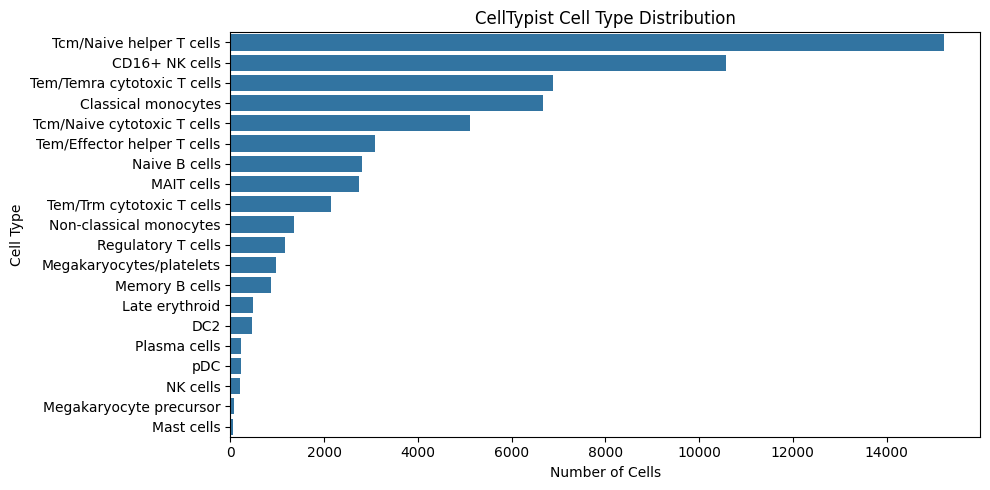

In [21]:
# Check CellTypist annotations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# View unique cell types and counts
print("CellTypist label value counts:")
print(adata.obs["celltypist_label"].value_counts())

# Plot cell type distribution
plt.figure(figsize=(10, 5))
sns.countplot(y=adata.obs["celltypist_label"], order=adata.obs["celltypist_label"].value_counts().index)
plt.title("CellTypist Cell Type Distribution")
plt.xlabel("Number of Cells")
plt.ylabel("Cell Type")
plt.tight_layout()
plt.show()

# Cross-tabulate cell type by disease
if "disease" in adata.obs.columns:
    ctab = pd.crosstab(adata.obs["celltypist_label"], adata.obs["disease"])
    print("\nCell type by disease:")
    print(ctab)
    ctab.plot(kind="bar", stacked=True, figsize=(12, 6))
    plt.title("Cell Type Distribution by Disease Status")
    plt.xlabel("Cell Type")
    plt.ylabel("Number of Cells")
    plt.tight_layout()
    plt.show()

## Merge annotations with processed AnnData 

In [22]:
# Ensure both AnnData objects are indexed by barcodes for merging and celltypist_label is populated
import scanpy as sc

celltypist_adata = sc.read_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_annotated.h5ad")
processed_adata = sc.read_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_processed.h5ad")

# Set index to barcodes for both AnnData objects if not already
if 'barcodes' in celltypist_adata.obs.columns:
    celltypist_adata.obs.index = celltypist_adata.obs['barcodes']
    celltypist_adata.obs.index.name = None
if 'barcodes' in processed_adata.obs.columns:
    processed_adata.obs.index = processed_adata.obs['barcodes']
    processed_adata.obs.index.name = None

print('First 5 rows of celltypist_adata.obs:')
print(celltypist_adata.obs.head())
print('First 5 rows of processed_adata.obs:')
print(processed_adata.obs.head())

# Diagnostics: Check barcode overlap between AnnData objects
barcodes_celltypist = set(celltypist_adata.obs.index)
barcodes_processed = set(processed_adata.obs.index)
print('Barcodes in celltypist AnnData:', len(barcodes_celltypist))
print('Barcodes in processed AnnData:', len(barcodes_processed))
print('Number of overlapping barcodes:', len(barcodes_celltypist & barcodes_processed))

# Check if celltypist_label exists and is populated in celltypist_adata
if 'celltypist_label' not in celltypist_adata.obs.columns or celltypist_adata.obs['celltypist_label'].isna().all():
    print('celltypist_label missing or all NaN in celltypist_adata. Please rerun CellTypist annotation.')
else:
    print('celltypist_label value counts in celltypist_adata:')
    print(celltypist_adata.obs['celltypist_label'].value_counts(dropna=False).head(20))
    # Merge CellTypist labels
    celltypist_labels = celltypist_adata.obs['celltypist_label']
    if 'celltypist_label' in processed_adata.obs.columns:
        processed_adata.obs = processed_adata.obs.drop(columns=['celltypist_label'])
    processed_adata.obs = processed_adata.obs.join(celltypist_labels, how='left')
    print('Processed AnnData celltypist_label value counts after merge:')
    print(processed_adata.obs['celltypist_label'].value_counts(dropna=False))
    processed_adata.write_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_annotated.h5ad")


First 5 rows of celltypist_adata.obs:
                               celltypist_label
AAACCTGAGACCTAGG-1  Tcm/Naive cytotoxic T cells
AAACCTGAGCCACCTG-1     Tcm/Naive helper T cells
AAACCTGAGTCATCCA-1          Classical monocytes
AAACCTGCAGATGAGC-1     Tcm/Naive helper T cells
AAACCTGCATCCGCGA-1          Classical monocytes
First 5 rows of processed_adata.obs:
                   batch cell_batch            barcodes disease  join_id  \
AAACCTGAGACCTAGG-1  HC-1       HC-1  AAACCTGAGACCTAGG-1  normal        1   
AAACCTGAGCCACCTG-1  HC-1       HC-1  AAACCTGAGCCACCTG-1  normal        1   
AAACCTGAGTCATCCA-1  HC-1       HC-1  AAACCTGAGTCATCCA-1  normal        1   
AAACCTGCAGATGAGC-1  HC-1       HC-1  AAACCTGCAGATGAGC-1  normal        1   
AAACCTGCATCCGCGA-1  HC-1       HC-1  AAACCTGCATCCGCGA-1  normal        1   

                    n_counts  n_counts_all leiden  
AAACCTGAGACCTAGG-1    7134.0      1.790213      6  
AAACCTGAGCCACCTG-1    4895.0      1.228356      4  
AAACCTGAGTCATCCA-1    69

# Pseudobulk data

In [31]:
import scanpy as sc

adata = sc.read_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_annotated.h5ad")

In [32]:
# Pseudobulk using adpbulk with available columns (without use_raw)
from adpbulk import ADPBulk

# Example: pseudobulk by celltypist_label and cell_batch (adjust as needed)
adpb = ADPBulk(adata, ["celltypist_label", "cell_batch"], use_raw=True)
pseudobulk_matrix = adpb.fit_transform()
sample_meta = adpb.get_meta()

print("Pseudobulk matrix shape:", pseudobulk_matrix.shape)
display(pseudobulk_matrix.head())
print("Sample metadata:")
display(sample_meta.head())

Aggregating Samples: 100%|██████████| 200/200 [00:15<00:00, 12.52it/s]

Pseudobulk matrix shape: (196, 33694)


RP11-34P13.3  FAM138A  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells              0.0      0.0   
cell_batch.HC-1-celltypist_label.Classical mono...           0.0      0.0   
cell_batch.HC-1-celltypist_label.DC2                         0.0      0.0   
cell_batch.HC-1-celltypist_label.Late erythroid              0.0      0.0   
cell_batch.HC-1-celltypist_label.MAIT cells                  0.0      0.0   

                                                    OR4F5  RP11-34P13.7  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells       0.0           0.0   
cell_batch.HC-1-celltypist_label.Classical mono...    0.0           0.0   
cell_batch.HC-1-celltypist_label.DC2                  0.0           1.0   
cell_batch.HC-1-celltypist_label.Late erythroid       0.0           0.0   
cell_batch.HC-1-celltypist_label.MAIT cells           0.0           0.0   

                                                    RP11-34P13.8  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells              0.0   
cell_batch.HC-1-celltypist_label.Classical mono...           0.0   
cell_batch.HC-1-celltypist_label.DC2                         0.0   
cell_batch.HC-1-celltypist_label.Late erythroid              0.0   
cell_batch.HC-1-celltypist_label.MAIT cells                  0.0   

                                                    RP11-34P13.14  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells               0.0   
cell_batch.HC-1-celltypist_label.Classical mono...            0.0   
cell_batch.HC-1-celltypist_label.DC2                          0.0   
cell_batch.HC-1-celltypist_label.Late erythroid               0.0   
cell_batch.HC-1-celltypist_label.MAIT cells                   0.0   

                                                    RP11-34P13.9  FO538757.3  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells              0.0         0.0   
cell_batch.HC-1-celltypist_label.Classical mono...           0.0         1.0   
cell_batch.HC-1-celltypist_label.DC2                         0.0         1.0   
cell_batch.HC-1-celltypist_label.Late erythroid              0.0         0.0   
cell_batch.HC-1-celltypist_label.MAIT cells                  0.0         0.0   

                                                    FO538757.2  AP006222.2  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells           82.0         1.0   
cell_batch.HC-1-celltypist_label.Classical mono...       140.0         2.0   
cell_batch.HC-1-celltypist_label.DC2                      43.0         0.0   
cell_batch.HC-1-celltypist_label.Late erythroid            0.0         0.0   
cell_batch.HC-1-celltypist_label.MAIT cells               35.0         1.0   

                                                    ...  AC007325.2  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells     ...         0.0   
cell_batch.HC-1-celltypist_label.Classical mono...  ...         0.0   
cell_batch.HC-1-celltypist_label.DC2                ...         0.0   
cell_batch.HC-1-celltypist_label.Late erythroid     ...         0.0   
cell_batch.HC-1-celltypist_label.MAIT cells         ...         0.0   

                                                    BX072566.1  AL354822.1  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells            0.0         0.0   
cell_batch.HC-1-celltypist_label.Classical mono...         0.0         1.0   
cell_batch.HC-1-celltypist_label.DC2                       0.0         0.0   
cell_batch.HC-1-celltypist_label.Late erythroid            0.0         0.0   
cell_batch.HC-1-celltypist_label.MAIT cells                0.0         1.0   

                                                    AC023491.2  AC004556.1  \
cell_batch.HC-1-celltypist_label.CD16+ NK cells            0.0         1.0   
cell_batch.HC-1-celltypist_label.Classical mono...         0.0         0.0   
cell_batch.HC-1-celltypist_label.DC2                       0.0         0.0   
cell_batch.HC-1-celltypist_label.Late erythroid            0.0         0.0   
cell_batch.HC-1-celltypist_label.MAIT cells                0.0         0.0   


Sample metadata:


cell_batch     celltypist_label  \
0       HC-1       CD16+ NK cells   
1       HC-1  Classical monocytes   
2       HC-1                  DC2   
3       HC-1       Late erythroid   
4       HC-1           MAIT cells   

                                          SampleName  
0    cell_batch.HC-1-celltypist_label.CD16+ NK cells  
1  cell_batch.HC-1-celltypist_label.Classical mon...  
2               cell_batch.HC-1-celltypist_label.DC2  
3    cell_batch.HC-1-celltypist_label.Late erythroid  
4        cell_batch.HC-1-celltypist_label.MAIT cells

In [33]:
# save pseudobulk matrix and metadata
pseudobulk_matrix.to_csv(f"{PDIR}/sjogrens-pbmc/outputs/sjogrens_pbmc_pseudobulk_matrix.csv")
sample_meta.to_csv(f"{PDIR}/sjogrens-pbmc/outputs/sjogrens_pbmc_pseudobulk_metadata.csv")

# Run pyDeSeq2

In [34]:
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import pickle as pkl

# Load pseudobulk matrix and metadata
counts = pd.read_csv(f"{PDIR}/sjogrens-pbmc/outputs/sjogrens_pbmc_pseudobulk_matrix.csv", index_col=0)
meta = pd.read_csv(f"{PDIR}/sjogrens-pbmc/outputs/sjogrens_pbmc_pseudobulk_metadata.csv", index_col=0)

# Set metadata index to SampleName column for alignment
if 'SampleName' in meta.columns:
    meta = meta.set_index('SampleName')

# Extract disease from cell_batch if not present
if 'disease' not in meta.columns and 'cell_batch' in meta.columns:
    meta['disease'] = meta['cell_batch'].str[:2].map({'HC': 'normal', 'pS': 'sjogren syndrome'})

# Align meta to counts index (samples)
meta_aligned = meta.reindex(counts.index)

# Drop samples with missing metadata
missing = meta_aligned.isnull().any(axis=1)
if missing.any():
    print("Warning: Missing metadata for samples:", meta_aligned.index[missing].tolist())
    counts = counts.loc[~missing, :]
    meta_aligned = meta_aligned.loc[~missing]

# Convert counts to integer if needed
if not all(counts.dtypes == 'int'):
    counts = counts.round().astype(int)

In [38]:
# Optional: use multi-core inference
inference = DefaultInference(n_cpus=8)

# Stepwise fitting for transparency and reproducibility
dds = DeseqDataSet(
    counts=counts,
    metadata=meta_aligned,
    design_factors=["disease"],
    refit_cooks=True,
    inference=inference,
    # design="~disease"  # Uncomment if you want to use formula syntax
    # control_genes=None # Optionally specify control genes for normalization
)
dds.fit_size_factors()
print("Size factors:")
print(dds.obs["size_factors"].head())
dds.fit_genewise_dispersions()
print("Genewise dispersions:")
print(dds.var["genewise_dispersions"].head())
dds.fit_dispersion_trend()
print("Dispersion trend coefficients:")
# print(dds.uns["trend_coeffs"])
dds.fit_dispersion_prior()
print(f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}")
dds.fit_MAP_dispersions()
print("MAP dispersions:")
print(dds.var["MAP_dispersions"].head())
dds.fit_LFC()
print("LFCs (natural log scale):")
print(dds.varm["LFC"][:5])
dds.calculate_cooks()
if dds.refit_cooks:
    dds.refit()
print("Cooks distances calculated and outliers refit if needed.")

# Save dds object for reproducibility
with open("dds_detailed_pipe.pkl", "wb") as f:
    pkl.dump(dds, f)

# Statistical analysis with DeseqStats
ds = DeseqStats(
    dds,
    contrast=["disease", "sjogren syndrome", "normal"],
    alpha=0.05,
    cooks_filter=True,
    independent_filter=True
)
ds.run_wald_test()
if ds.cooks_filter:
    ds._cooks_filtering()
if ds.independent_filter:
    ds._independent_filtering()
else:
    ds._p_value_adjustment()
print("Adjusted p-values:")
print(ds.padj.head())
ds.summary()
res_df = ds.results_df
print(res_df.head())
# LFC shrinkage (recommended for visualization)
ds.lfc_shrink(coeff="disease[T.sjogren syndrome]")
print("Shrunk log2 fold changes:")
print(ds.results_df.head())
# Save ds object for reproducibility
with open("ds_detailed_pipe.pkl", "wb") as f:
    pkl.dump(ds, f)

Using None as control genes, passed at DeseqDataSet initialization
Size factors:
cell_batch.HC-1-celltypist_label.CD16+ NK cells         3.371791
cell_batch.HC-1-celltypist_label.Classical monocytes    5.072432
cell_batch.HC-1-celltypist_label.DC2                    1.525470
cell_batch.HC-1-celltypist_label.Late erythroid         0.001609
cell_batch.HC-1-celltypist_label.MAIT cells             3.855980
Name: size_factors, dtype: float64


/var/folders/p2/rh6xbt2n0nj6rn3qqpc7s1_m0000gn/T/ipykernel_21774/3573677855.py:5: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 2.23 seconds.

Fitting dispersion trend curve...


Genewise dispersions:
RP11-34P13.3    1.000000e-08
FAM138A                  NaN
OR4F5                    NaN
RP11-34P13.7    1.000000e-08
RP11-34P13.8             NaN
Name: genewise_dispersions, dtype: float64


... done in 0.28 seconds.

Fitting MAP dispersions...


Dispersion trend coefficients:
logres_prior=3.023934458194479, sigma_prior=3.01357185662401


... done in 2.81 seconds.

Fitting LFCs...


MAP dispersions:
RP11-34P13.3    196.000000
FAM138A                NaN
OR4F5                  NaN
RP11-34P13.7      5.084801
RP11-34P13.8           NaN
Name: MAP_dispersions, dtype: float64


... done in 2.84 seconds.

Calculating cook's distance...
... done in 0.19 seconds.



LFCs (natural log scale):
              Intercept  disease[T.sjogren syndrome]
RP11-34P13.3  -1.005609                     0.003928
FAM138A             NaN                          NaN
OR4F5               NaN                          NaN
RP11-34P13.7  -0.967609                    -0.034525
RP11-34P13.8        NaN                          NaN


Replacing 884 outlier genes.

Fitting dispersions...
... done in 0.17 seconds.

Fitting MAP dispersions...
... done in 0.13 seconds.

Fitting LFCs...
... done in 0.13 seconds.



Cooks distances calculated and outliers refit if needed.


Running Wald tests...
... done in 1.43 seconds.

Fitting MAP LFCs...


Adjusted p-values:
RP11-34P13.3   NaN
FAM138A        NaN
OR4F5          NaN
RP11-34P13.7   NaN
RP11-34P13.8   NaN
Name: 20, dtype: float64
Log2 fold change & Wald test p-value: disease sjogren syndrome vs normal
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
RP11-34P13.3  0.000873        0.005667  3.007528  0.001884  0.998496       NaN
FAM138A       0.000000             NaN       NaN       NaN       NaN       NaN
OR4F5         0.000000             NaN       NaN       NaN       NaN       NaN
RP11-34P13.7  0.053972       -0.049809  0.586868 -0.084872  0.932363       NaN
RP11-34P13.8  0.000000             NaN       NaN       NaN       NaN       NaN
...                ...             ...       ...       ...       ...       ...
AC233755.2    0.369419       -1.171393  1.473282 -0.795091  0.426561  0.661160
AC233755.1    1.914929       -0.816421  1.488425 -0.548513  0.583340  0.795381
AC240274.1    0.763364       -0.034698  0.204647 -0.169550  0.865364  0.95809

... done in 2.32 seconds.



## Save results

In [39]:
# Save DESeq2 results
res_df.to_csv(f"{PDIR}/sjogrens-pbmc/outputs/sjogrens_pbmc_deseq2_results.csv")

## Plot pyDeSeq2 results

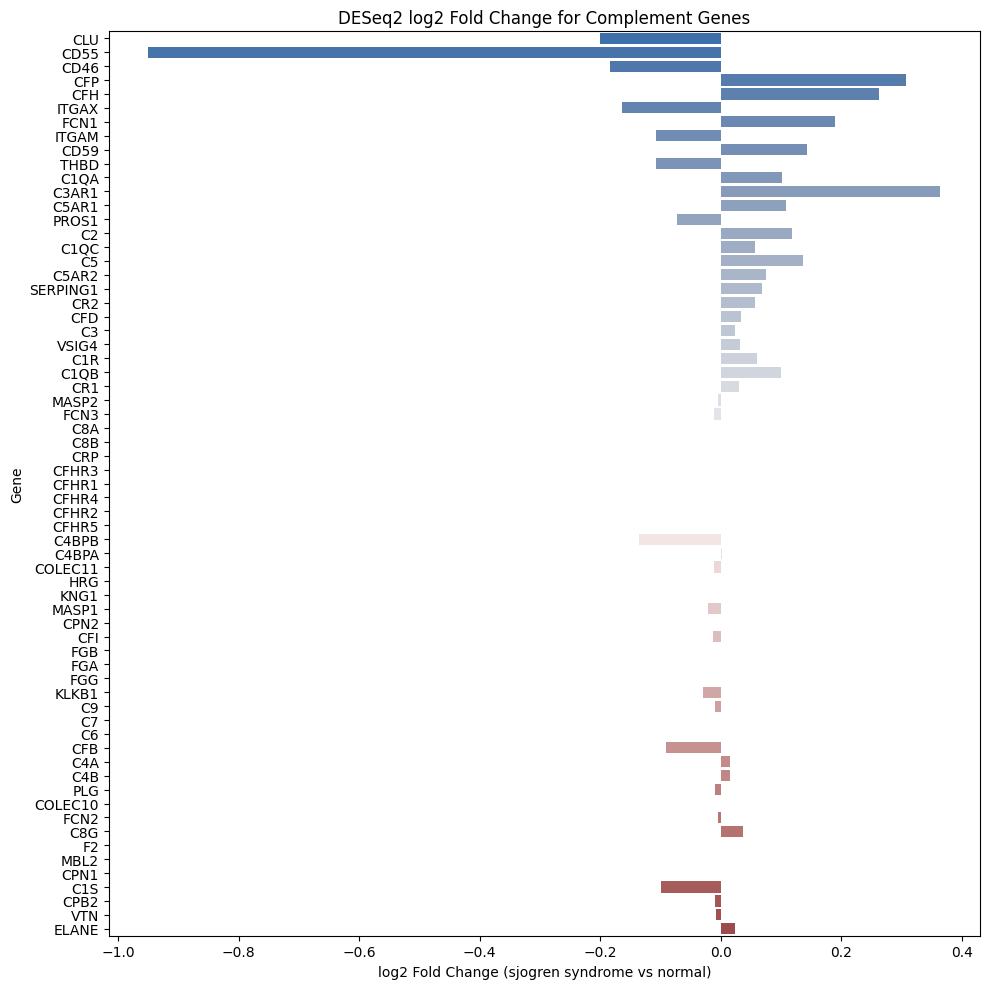

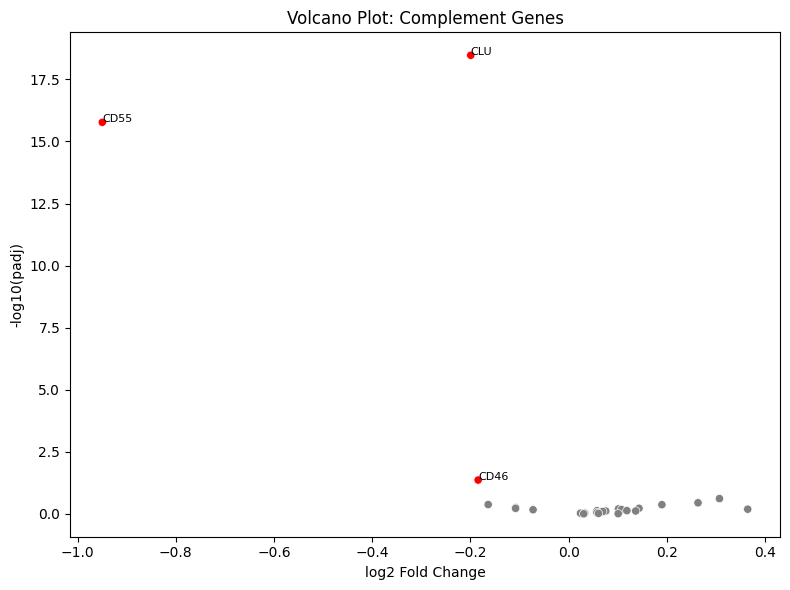

In [46]:
# Plot DESeq2 results for complement genes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load complement gene list
with open(f"{PDIR}/resources/complement-genes.txt") as f:
    complement_genes = [line.strip() for line in f if line.strip()]

# Filter DESeq2 results for complement genes
complement_res = res_df[res_df.index.isin(complement_genes)].copy()

# Sort by adjusted p-value
complement_res = complement_res.sort_values("padj")

# Plot log2 fold change for complement genes
plt.figure(figsize=(10, 10))
sns.barplot(
    y=complement_res.index,
    x=complement_res["log2FoldChange"],
    palette="vlag"
)
plt.xlabel("log2 Fold Change (sjogren syndrome vs normal)")
plt.ylabel("Gene")
plt.title("DESeq2 log2 Fold Change for Complement Genes")
plt.tight_layout()
plt.show()

# Volcano plot for complement genes
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=complement_res["log2FoldChange"],
    y=-np.log10(complement_res["padj"]),
    hue=(complement_res["padj"] < 0.05),
    palette={True: "red", False: "grey"},
    legend=False
)
for gene, row in complement_res.iterrows():
    if row["padj"] < 0.05:
        plt.text(row["log2FoldChange"], -np.log10(row["padj"]), gene, fontsize=8)
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10(padj)")
plt.title("Volcano Plot: Complement Genes")
plt.tight_layout()
plt.show()

### MA Plot for all genes

In [44]:
# Ensure DESeq2 results are loaded into res_df before plotting
# If you have a DeseqStats object named 'ds', use the following line:
res_df = ds.results_df

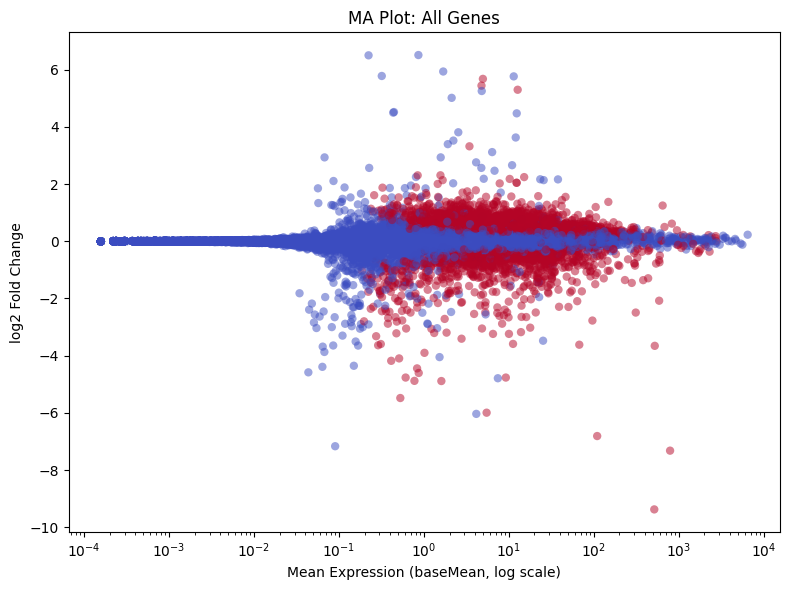

In [45]:
import numpy as np

plt.figure(figsize=(8,6))
plt.scatter(res_df['baseMean'], res_df['log2FoldChange'],
            c=(res_df['padj'] < 0.05), cmap='coolwarm', alpha=0.5, edgecolor='none')
plt.xscale('log')
plt.xlabel('Mean Expression (baseMean, log scale)')
plt.ylabel('log2 Fold Change')
plt.title('MA Plot: All Genes')
plt.tight_layout()
plt.show()

### Heatmap of top differentially expressed complement genes

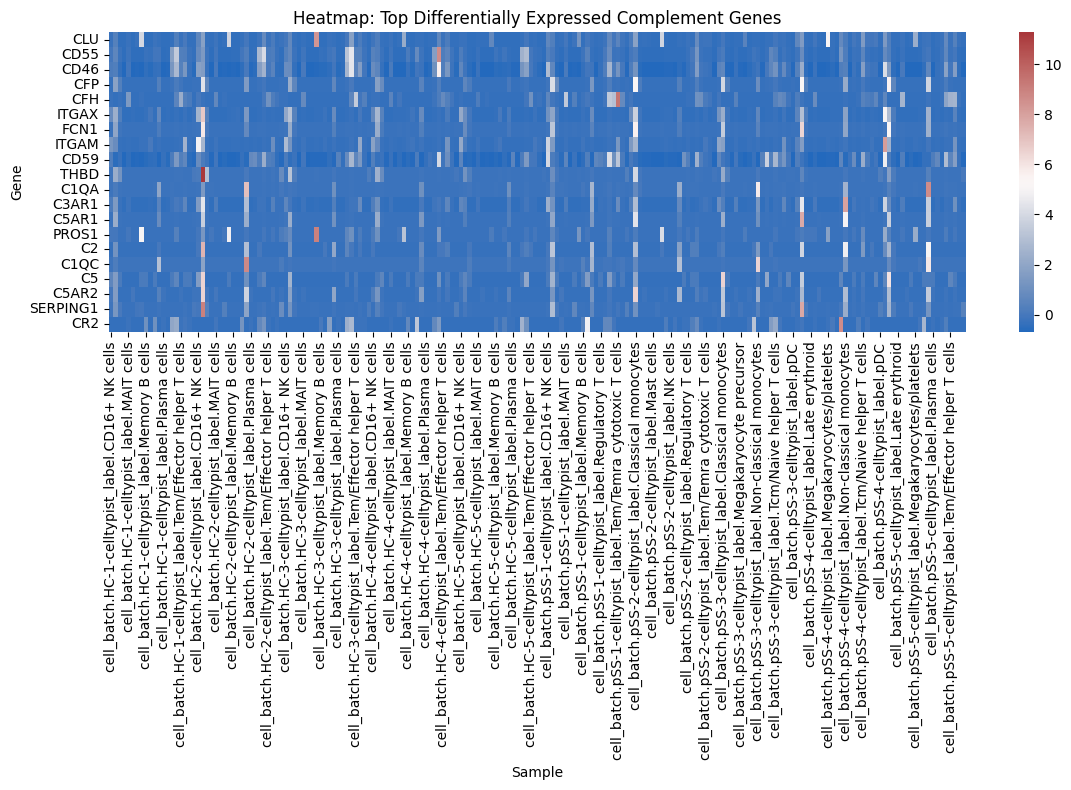

In [41]:
import seaborn as sns

# Select top 20 by adjusted p-value
n_top = 20
top_complement = complement_res.nsmallest(n_top, 'padj')
# Load normalized counts if available, else use counts
try:
    norm_counts = dds.norm_counts
except AttributeError:
    norm_counts = counts
# If genes are columns, transpose so genes are rows
genes_in_columns = set(top_complement.index).issubset(norm_counts.columns)
if genes_in_columns:
    heatmap_data = norm_counts[top_complement.index].T
else:
    heatmap_data = norm_counts.loc[top_complement.index]
# Z-score normalization for visualization (pandas broadcasting, no keepdims)
heatmap_data = (heatmap_data.subtract(heatmap_data.mean(axis=1), axis=0)).divide(heatmap_data.std(axis=1), axis=0)
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, cmap='vlag', yticklabels=top_complement.index)
plt.title('Heatmap: Top Differentially Expressed Complement Genes')
plt.xlabel('Sample')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

### Lollipop plot: complement genes ranked by -log10(padj)

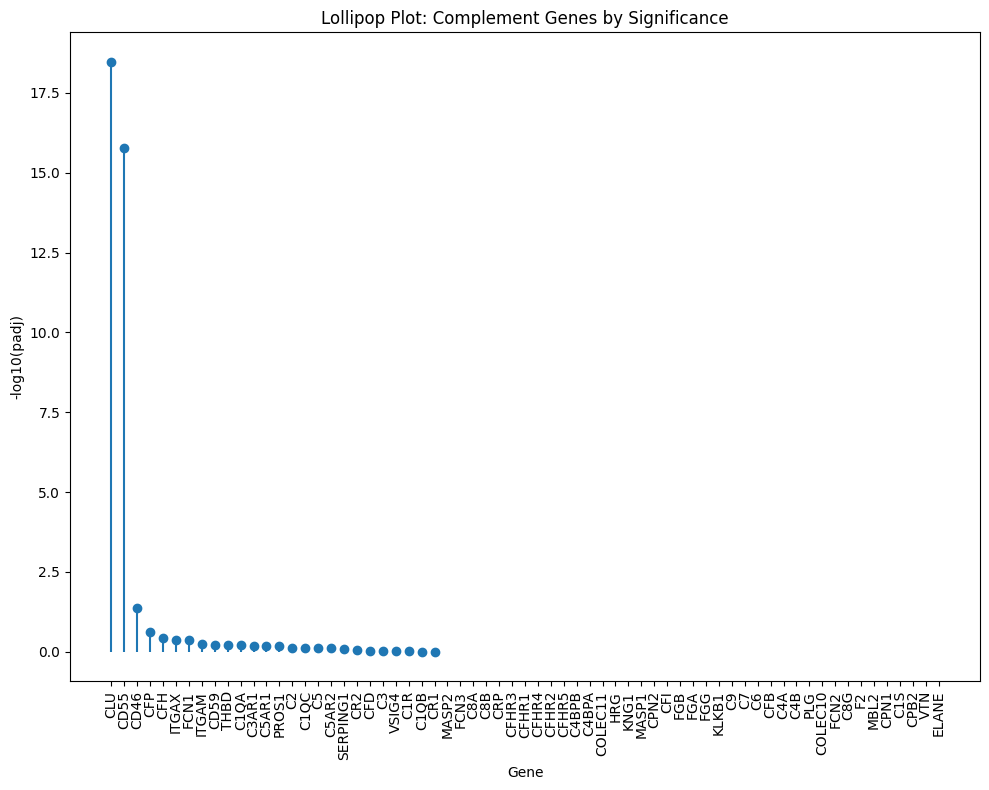

In [42]:
complement_res['-log10_padj'] = -np.log10(complement_res['padj'])
complement_res_sorted = complement_res.sort_values('-log10_padj', ascending=False)
plt.figure(figsize=(10, 8))
# Removed use_line_collection for compatibility with newer matplotlib
plt.stem(complement_res_sorted.index, complement_res_sorted['-log10_padj'], basefmt=" ")
plt.xticks(rotation=90)
plt.ylabel('-log10(padj)')
plt.xlabel('Gene')
plt.title('Lollipop Plot: Complement Genes by Significance')
plt.tight_layout()
plt.show()

### Boxplots for selected complement genes (top 5 by significance)

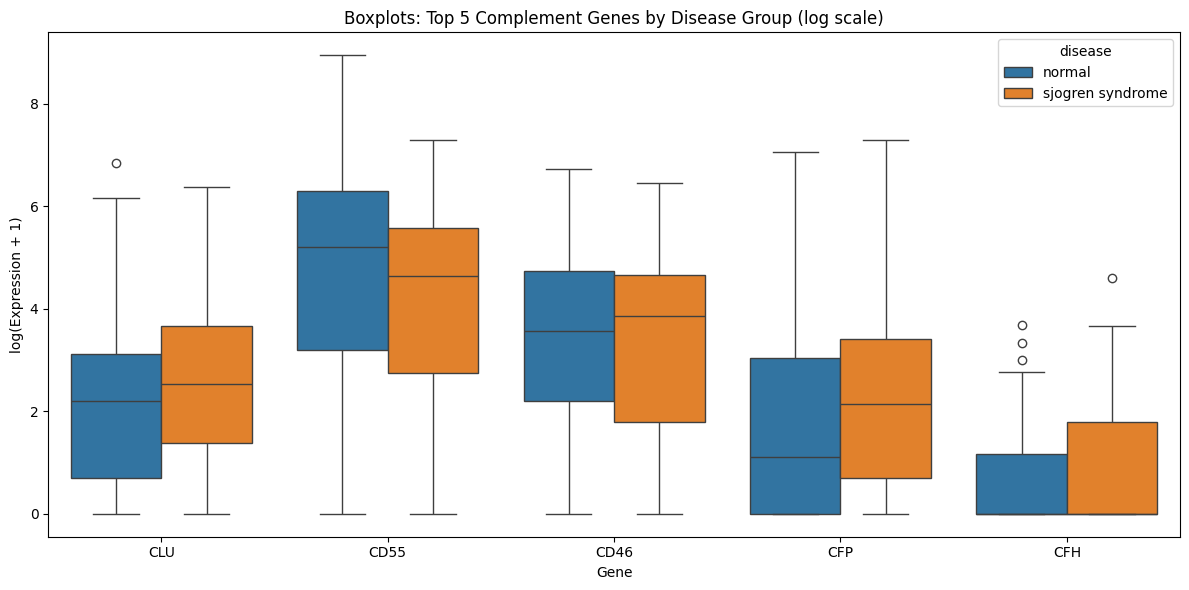

In [43]:
# Check if genes are in index or columns
top5 = complement_res.nsmallest(5, 'padj').index.tolist()
if set(top5).issubset(norm_counts.index):
    plot_data = norm_counts.loc[top5].T.reset_index().melt(id_vars='index', var_name='Gene', value_name='Expression')
elif set(top5).issubset(norm_counts.columns):
    plot_data = norm_counts[top5].reset_index().melt(id_vars='index', var_name='Gene', value_name='Expression')
else:
    raise KeyError(f"None of {top5} are in the index or columns of norm_counts")
# Add disease group info
plot_data = plot_data.rename(columns={'index': 'Sample'})
if 'disease' in meta_aligned.columns:
    plot_data = plot_data.merge(meta_aligned[['disease']], left_on='Sample', right_index=True, how='left')
# Log-transform expression (add small constant to avoid log(0))
plot_data['log_Expression'] = np.log1p(plot_data['Expression'])
plt.figure(figsize=(12, 6))
sns.boxplot(x='Gene', y='log_Expression', hue='disease', data=plot_data)
plt.title('Boxplots: Top 5 Complement Genes by Disease Group (log scale)')
plt.ylabel('log(Expression + 1)')
plt.tight_layout()
plt.show()

# LIANA

## Tensor-Cell2Cell

Tensor decomposition of cell-cell communication patterns, as proposed by Armingol and Baghdassarian et al., 2022, enables us to decipher context-driven intercellular communication by simultaneously accounting for an unlimited number of “contexts”. These contexts could represent samples coming from longtidinal sampling points, multiple conditions, or cellular niches.

The power of Tensor-cell2cell is in its ability to decompose latent patterns of intercellular communication in an untargeted manner, in theory being able to handle cell-cell communication results coming from any experimental design, regardless of its complexity.

Simply put, tensor_cell2cell uses LIANA’s output by sample to build a 4D tensor, represented by 1) contexts, 2) interactions, 3) sender, and 4) receiver cell types. This tensor is then decomposed into a set of factors, which can be interpreted as low-dimensionality latent variables (vectors) that capture the CCC patterns across contexts. We will combine LIANA with tensor_cell2cell to decipher potential ligand-receptor interaction changes.

### Load and modify AnnData

In [3]:
# Load processed AnnData object (already normalized/log1p in previous steps)
import scanpy as sc
import os

adata = sc.read_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_annotated.h5ad")

/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packag

In [4]:
# Map Ensembl IDs to gene symbols for LIANA compatibility
import mygene
import numpy as np

# Only run if not already mapped
if 'gene_symbols' not in adata.var.columns or adata.var['gene_symbols'].isnull().all():
    mg = mygene.MyGeneInfo()
    ensembl_ids = adata.var.index.tolist()
    print(f"Querying mygene for {len(ensembl_ids)} Ensembl IDs...")
    result = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')
    symbol_map = {r['query']: r.get('symbol') for r in result if 'symbol' in r and r.get('symbol')}
    adata.var['gene_symbols'] = adata.var.index.map(symbol_map)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Querying mygene for 19999 Ensembl IDs...


8 input query terms found dup hits:	[('ENSG00000227110', 2), ('ENSG00000257545', 2), ('ENSG00000259182', 2), ('ENSG00000276241', 4), ('E
666 input query terms found no hit:	['ENSG00000230699', 'ENSG00000236948', 'ENSG00000277726', 'ENSG00000271895', 'ENSG00000226849', 'ENS


In [5]:
# Filter out genes without a symbol
valid = adata.var['gene_symbols'].notnull()
adata = adata[:, valid].copy()

# Set gene symbols as var_names for LIANA
adata.var_names = adata.var['gene_symbols']
adata.var_names_make_unique()
print('First 10 gene symbols:', adata.var_names[:10])

# Ensure required columns exist and are categorical
for col in ['celltypist_label', 'batch', 'disease']:
    if col not in adata.obs.columns:
        raise ValueError(f"Column '{col}' missing in adata.obs. Please check your annotation steps.")
    adata.obs[col] = adata.obs[col].astype('category')

# For LIANA, set cell type, sample, and condition columns
adata.obs['cell_type'] = adata.obs['celltypist_label']
adata.obs['sample'] = adata.obs['batch']
adata.obs['condition'] = adata.obs['disease']

print('adata.obs columns:', adata.obs.columns.tolist())
print('Unique cell types:', adata.obs["cell_type"].unique())
print('Unique samples:', adata.obs["sample"].unique())
print('Unique conditions:', adata.obs["condition"].unique())

First 10 gene symbols: Index(['MIR1302-2HG', 'DDX11L17', 'WASH9P', 'RPL23AP21', 'LINC01409',
       'LINC00115', 'FAM41C', 'SAMD11', 'PLEKHN1', 'PERM1'],
      dtype='object', name='gene_symbols')
adata.obs columns: ['batch', 'cell_batch', 'barcodes', 'disease', 'join_id', 'n_counts', 'n_counts_all', 'leiden', 'celltypist_label', 'cell_type', 'sample', 'condition']
Unique cell types: ['Tcm/Naive cytotoxic T cells', 'Tcm/Naive helper T cells', 'Classical monocytes', 'Tem/Temra cytotoxic T cells', 'Tem/Effector helper T cells', ..., 'NK cells', 'Late erythroid', 'Mast cells', 'pDC', 'Plasma cells']
Length: 20
Categories (20, object): ['CD16+ NK cells', 'Classical monocytes', 'DC2', 'Late erythroid', ..., 'Tem/Effector helper T cells', 'Tem/Temra cytotoxic T cells', 'Tem/Trm cytotoxic T cells', 'pDC']
Unique samples: ['HC-1', 'HC-2', 'HC-3', 'HC-4', 'HC-5', 'pSS-1', 'pSS-2', 'pSS-3', 'pSS-4', 'pSS-5']
Categories (10, object): ['HC-1', 'HC-2', 'HC-3', 'HC-4', ..., 'pSS-2', 'pSS-3', 'pSS-4'

### Set-up for Tensor-cell2cell — Run, Build, Metadata

In [6]:
# Set up device for tensor-cell2cell
import torch
import tensorly as tl

# Try to use MPS if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = "mps"
    tl.set_backend('pytorch')
elif torch.cuda.is_available():
    device = "cuda"
    tl.set_backend('pytorch')
else:
    device = "cpu"
    tl.set_backend('pytorch')

print("Using device:", device)

Using device: mps


In [7]:
# Import LIANA, cell2cell, decoupler, and supporting packages
import liana as li
import cell2cell as c2c
import decoupler as dc
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

# Run LIANA by sample (consensus resource, robust rank aggregation)
li.mt.rank_aggregate.by_sample(
    adata,
    groupby='cell_type',
    resource_name='consensus',
    sample_key='sample',
    use_raw=False,
    verbose=True,
    n_perms=None,
    return_all_lrs=True,
)

# Save LIANA results for reproducibility
liana_outfile = os.path.join(PDIR, 'sjogrens-pbmc/outputs/liana_by_sample.csv')
adata.uns['liana_res'].to_csv(liana_outfile)
print(f"Saved LIANA results to {liana_outfile}")

Now running: pSS-5: 100%|██████████| 10/10 [05:05<00:00, 30.57s/it]


Saved LIANA results to /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade/sjogrens-pbmc/outputs/liana_by_sample.csv


In [8]:
# Build tensor for Tensor-cell2cell using a valid score column
tensor = li.multi.to_tensor_c2c(
    adata,
    sample_key='sample',
    score_key='scaled_weight',  # or 'lrscore' if you prefer
    how='outer_cells'
)
print("Tensor shape (Contexts, Interactions, Senders, Receivers):", tensor.tensor.shape)

# Save tensor object
import cell2cell as c2c
tensor_outfile = os.path.join(PDIR, 'sjogrens-pbmc/outputs/liana_tensor.pkl')
c2c.io.export_variable_with_pickle(tensor, tensor_outfile)
print(f"Saved tensor to {tensor_outfile}")

100%|██████████| 10/10 [11:46<00:00, 70.65s/it]


Tensor shape (Contexts, Interactions, Senders, Receivers): torch.Size([10, 2334, 20, 20])
/Users/aumchampaneri/VSCode Projects/complement-receptor-blockade/sjogrens-pbmc/outputs/liana_tensor.pkl  was correctly saved.
Saved tensor to /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade/sjogrens-pbmc/outputs/liana_tensor.pkl


In [9]:
# Build metadata for tensor decomposition
context_dict = adata.obs[['sample', 'condition']].drop_duplicates()
context_dict = dict(zip(context_dict['sample'], context_dict['condition']))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(
    interaction_tensor=tensor,
    metadata_dicts=[context_dict, None, None, None],
    fill_with_order_elements=True,
)

### Run Tensor-cell2cell

In [ ]:
# Run Tensor-cell2cell decomposition (auto rank estimation, can set rank=int for speed/reproducibility)
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(
    tensor,
    tensor_meta,
    copy_tensor=None,
    rank=None,  # Set rank to 3 (or try 4, 5, etc.)
    tf_optimization='regular',
    random_state=0,
    device=device,
    elbow_metric='error',
    smooth_elbow=False,
    upper_rank=20,
    tf_init='random',
    tf_svd='numpy_svd',
    cmaps=None,
    sample_col='Element',
    group_col='Category',
    output_fig=False,
)

Device not available or backend does not support this device.
Running Elbow Analysis


 25%|██▌       | 5/20 [09:17<30:01, 120.10s/it]

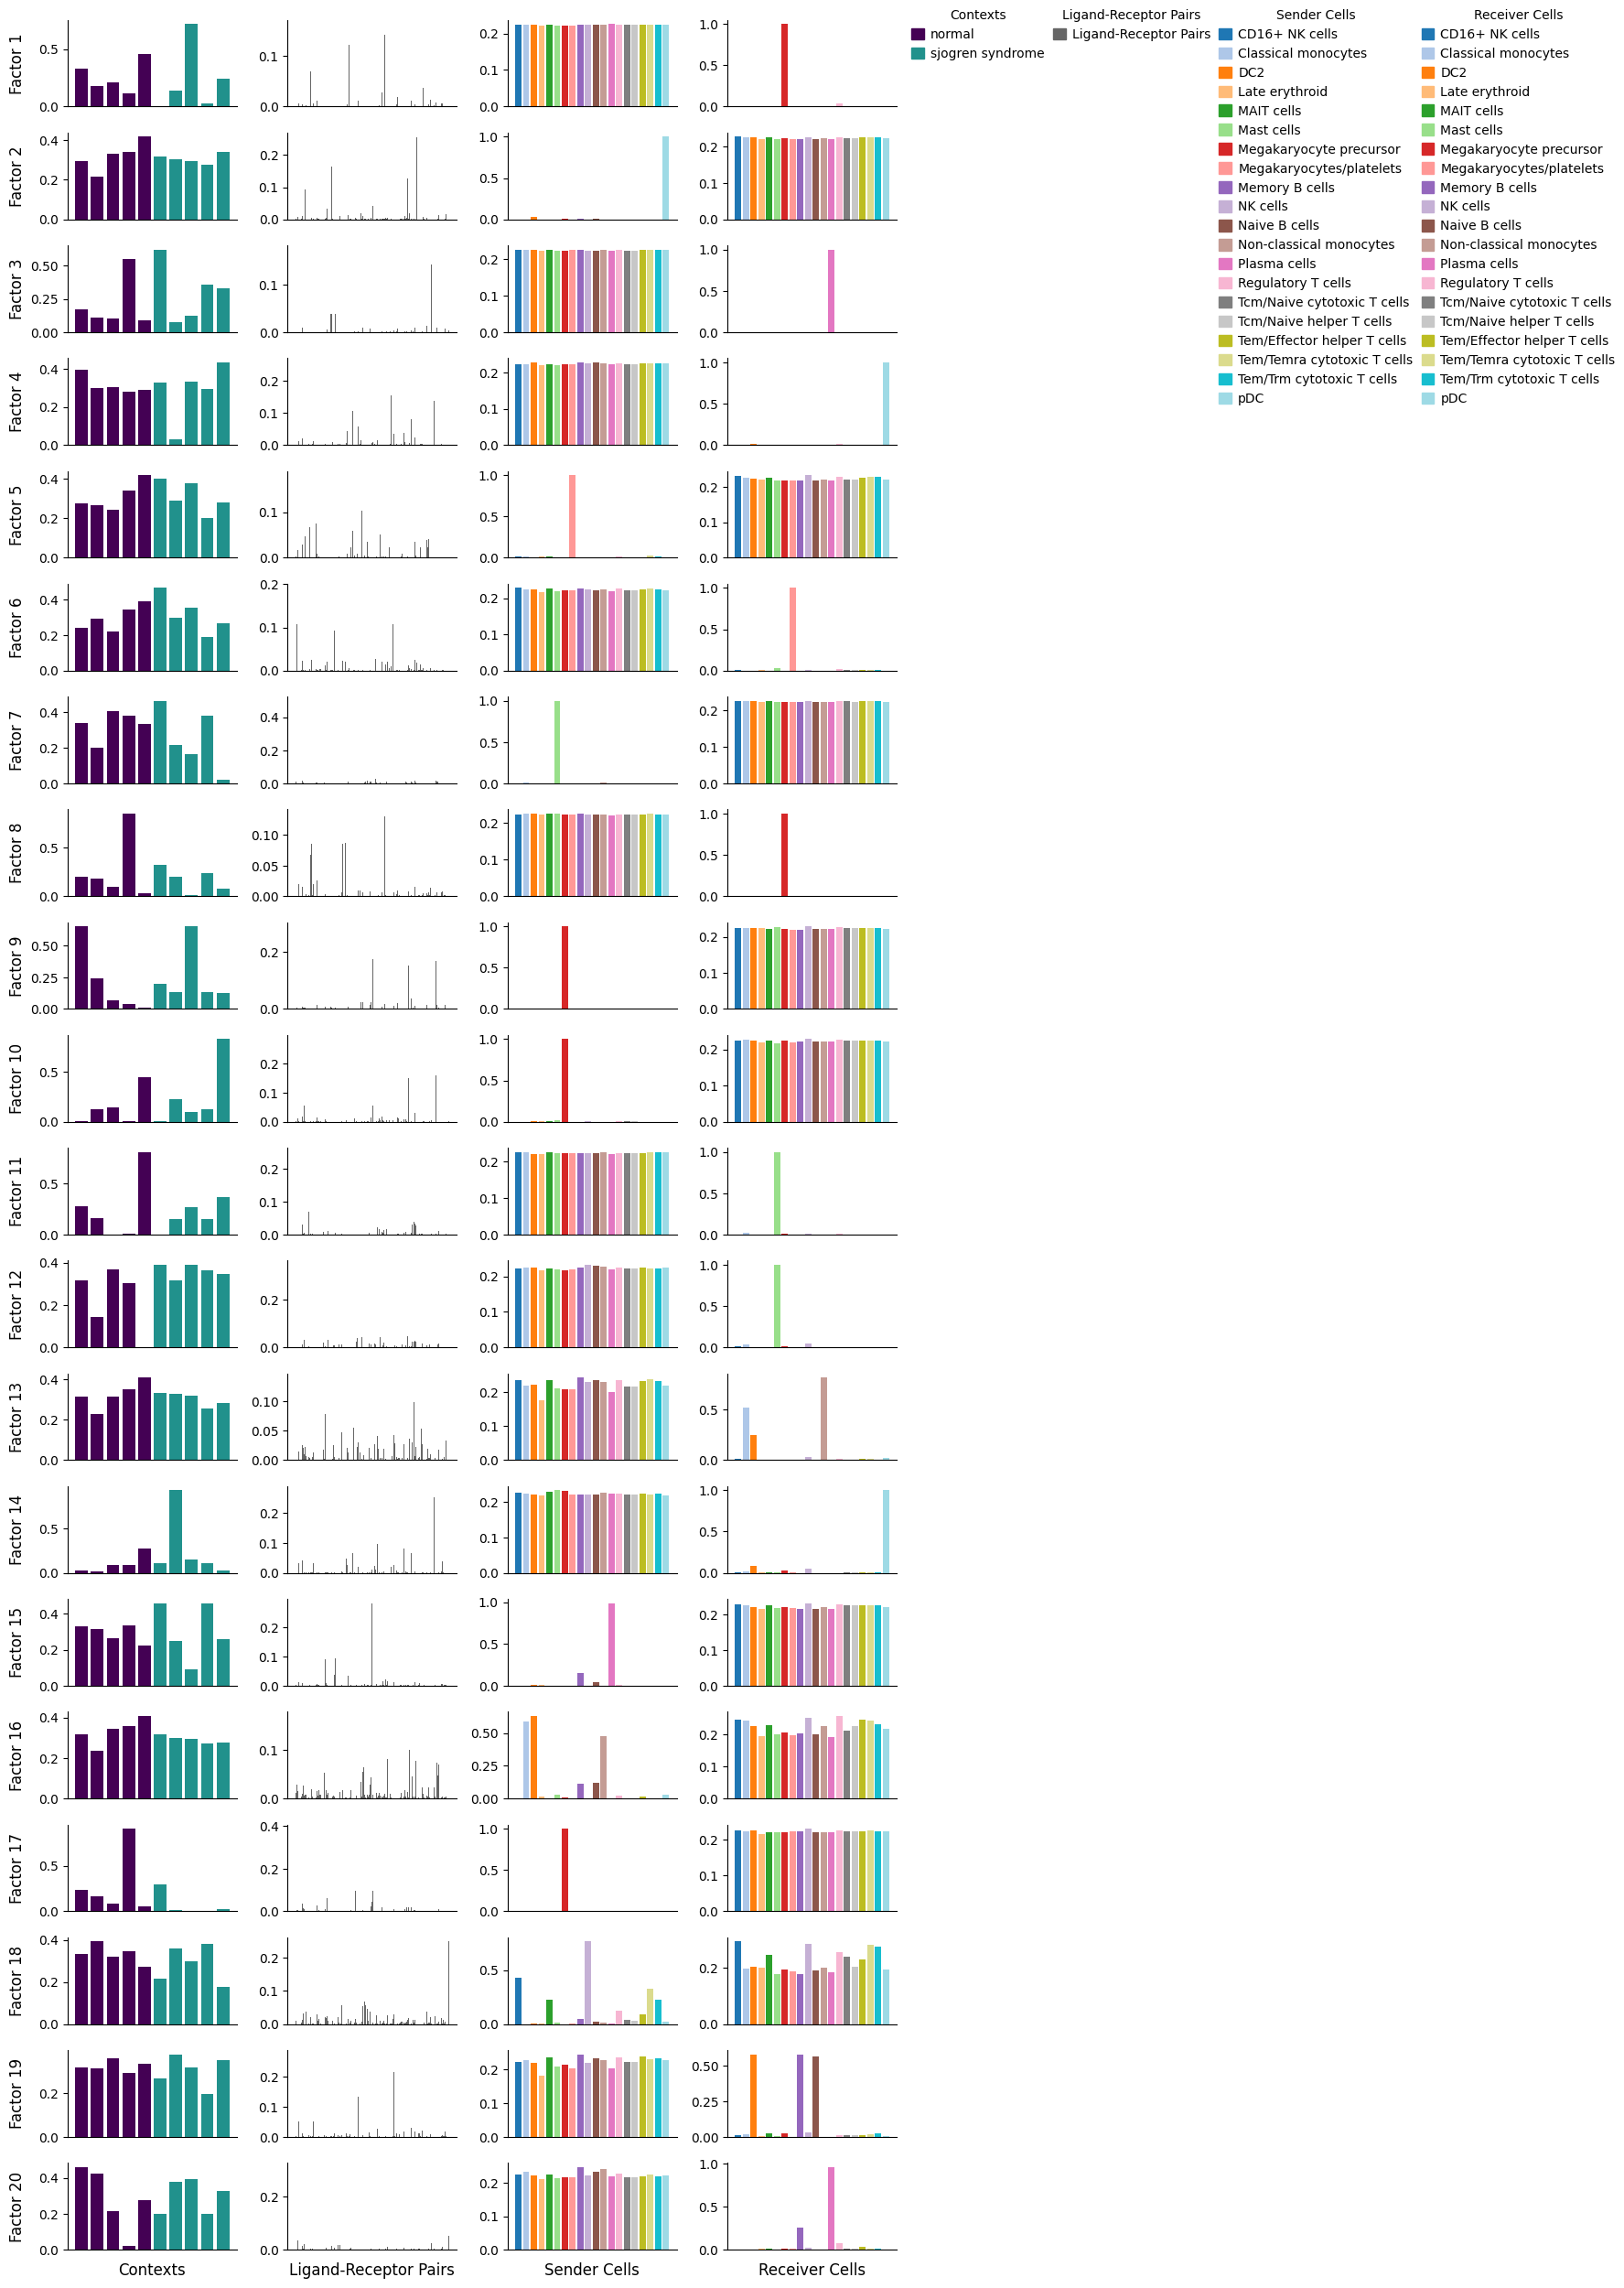

In [18]:
# Plot tensor factors (latent CCC patterns)
factors, axes = c2c.plotting.tensor_factors_plot(
    interaction_tensor=tensor,
    metadata=tensor_meta,
    sample_col='Element',
    group_col='Category',
    meta_cmaps=['viridis', 'Dark2_r', 'tab20', 'tab20'],
    fontsize=10,
)

### Factorization results

In [ ]:
# Access factors and loadings
factors = tensor.factors
print(factors.keys())  # Should show Contexts, Ligand-Receptor Pairs, Sender Cells, Receiver Cells

# Show top ligand-receptor pairs for a factor (e.g., Factor 1)
lr_loadings = factors['Ligand-Receptor Pairs']
lr_loadings.sort_values('Factor 1', ascending=False).head(10)

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])


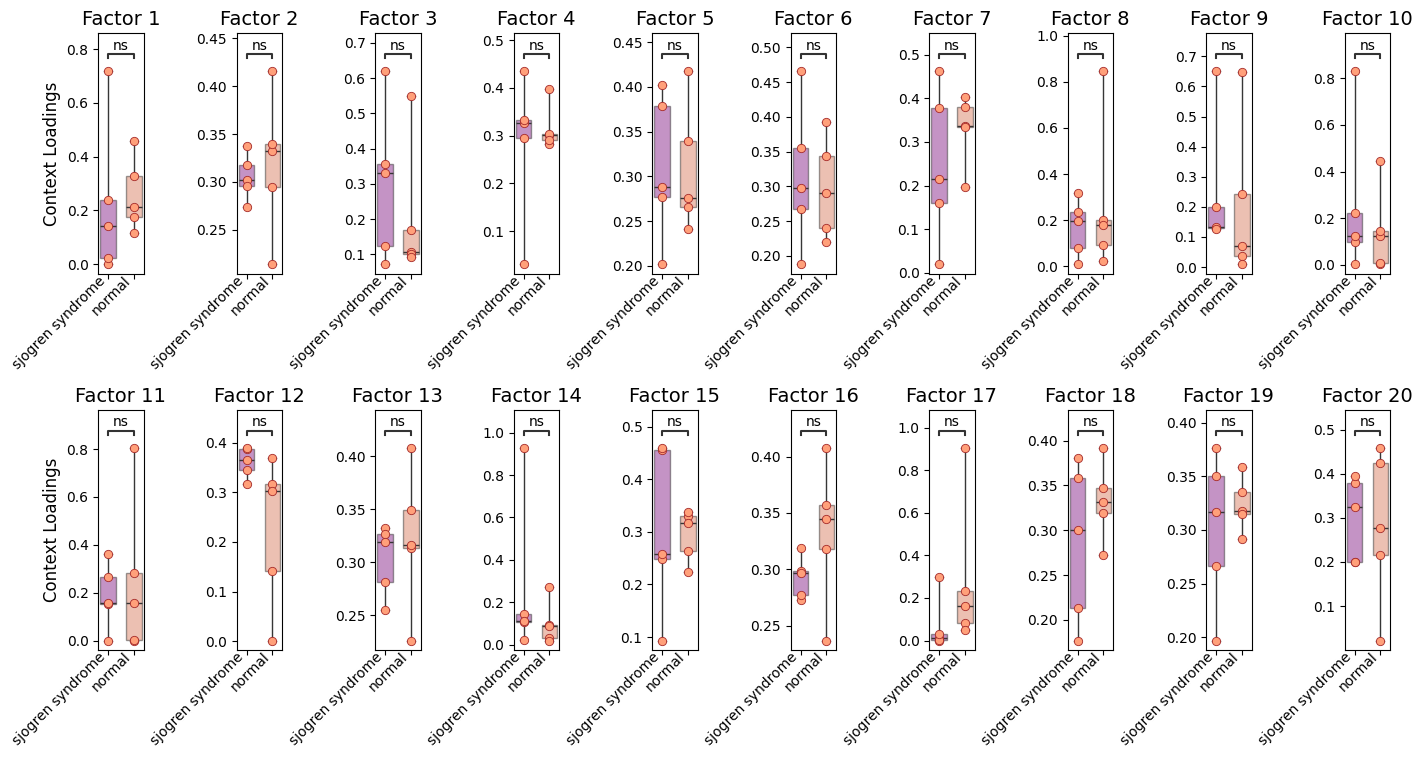

In [25]:
# Visualize context loadings (boxplot)
_ = c2c.plotting.context_boxplot(
    context_loadings=factors['Contexts'],
    metadict=context_dict,  # Make sure context_dict maps context names to metadata
    nrows=2,
    figsize=(14, 8),
    statistical_test='t-test_ind',
    pval_correction='fdr_bh',
    cmap='plasma',
    verbose=False,
)

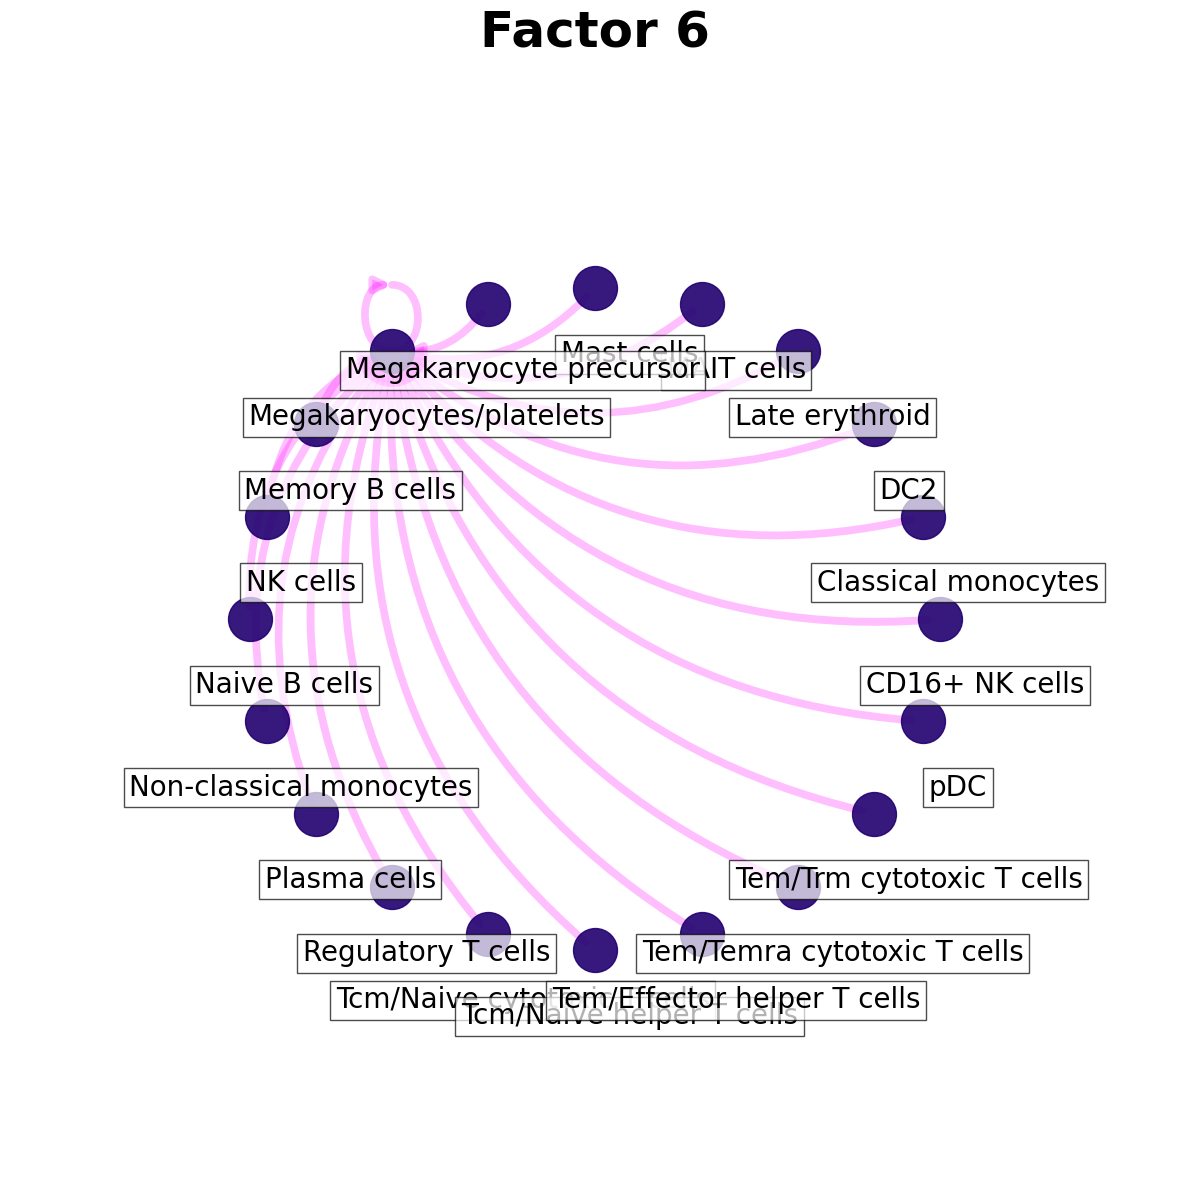

In [28]:
# Visualize CCC networks for a factor of interest (e.g., Factor 1 or 2, adjust as needed)
_ = c2c.plotting.ccc_networks_plot(
    factors,
    included_factors=['Factor 6'],  # Change to your factor of interest
    network_layout='circular',
    ccc_threshold=0.05,
    nrows=1,
    panel_size=(12, 12),
)

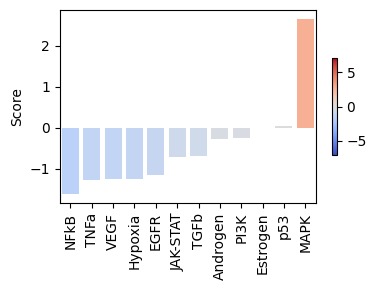

In [ ]:
# Optional: Pathway enrichment analysis for factors
import decoupler as dc
# Load PROGENy pathways
net = dc.op.progeny(organism='human', top=5000)
# Load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')
# Generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^").rename(columns={"interaction": "target"})
lr_progeny.head()
# Run enrichment
estimate, pvals = dc.mt.ulm(tensor.factors['Ligand-Receptor Pairs'].transpose(), lr_progeny, raw=False)
# Plot enrichment for a factor (e.g., 'Factor 1')
dc.pl.barplot(estimate, 'Factor 1', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)


## DEA for CCC & Signaling Networks

Cell-cell communication (CCC) events play a critical role in diseases, often experiencing deregulation. To identify differential expression of CCC events between conditions, we can build upon standard differential expression analysis (DEA) approaches, such as DESeq2. While dimensionality reduction methods like extracting intercellular programmes with MOFA+ and Tensor-cell2cell reduce CCC into sets of loadings, hypothesis-driven DEA tests focus on individual gene changes, making them easier to understand and interpret.

## Steady-state Ligand-Receptor inference

liana provides different statistical methods to infer ligand-receptor interactions from single-cell transcriptomics data omics data using prior knowledge. In this notebook we showcase how to use liana in its most basic form with toy data.

## MOFA

# Receptor-Ligand Analysis - LIANA

In [1]:
# Multi-Resource LIANA Receptor-Ligand Analysis & Consensus Aggregation for Sjogrens PBMC
# Adapted for this notebook and data structure

import os
import pandas as pd
import scanpy as sc

try:
    import liana as li
except ImportError:
    raise ImportError("Please install liana: pip install liana")

# ------------------- Configurable Paths -------------------
DATA_PATH = "../sjogrens-pbmc/input-data/sjogrens-pbmc_annotated.h5ad"
GENE_LIST_PATH = "../resources/complement-genes.txt"
OUTDIR = "../sjogrens-pbmc/outputs/liana_rla/"
os.makedirs(OUTDIR, exist_ok=True)

RESOURCES = ["cellphonedb", "cellchatdb", "icellnet", "connectomedb2020"]

# ------------------- Load Data -------------------
print("Loading AnnData from:", DATA_PATH)
adata = sc.read_h5ad(DATA_PATH)
if "celltypist_label" not in adata.obs.columns:
    raise ValueError("AnnData must have 'celltypist_label' annotation in .obs.")

print("Loading complement gene list from:", GENE_LIST_PATH)
complement_genes = pd.read_csv(GENE_LIST_PATH, header=None)[0].str.strip().tolist()
print(f"Loaded {len(complement_genes)} complement genes.")

# ------------------- Diagnostics and Fallback for Gene Symbol Mapping -------------------
print("First 10 genes in AnnData:", list(adata.var_names[:10]))
print("First 10 complement genes:", complement_genes[:10])

# Check overlap
overlap = set(g.upper() for g in adata.var_names) & set(g.upper() for g in complement_genes)
print(f"Number of complement genes present in AnnData: {len(overlap)}")

if len(overlap) > 0:
    print("Gene symbols in AnnData match complement gene list. Using gene symbols directly.")
    adata.var["gene_symbol"] = adata.var_names
else:
    print("Gene symbols in AnnData do not match complement gene list. Attempting Ensembl-to-symbol mapping with mygene...")
    import mygene
    mg = mygene.MyGeneInfo()
    ensembl_ids = adata.var_names.tolist()
    query_results = mg.querymany(
        ensembl_ids,
        scopes="ensembl.gene",
        fields="symbol",
        species="human",
        as_dataframe=True,
    )
    # Robustly handle missing 'symbol' column
    if "symbol" in query_results.columns:
        id_to_symbol = query_results["symbol"].to_dict()
    else:
        # Fallback: use index as keys, empty string as value
        id_to_symbol = {eid: "" for eid in ensembl_ids}
    adata.var["gene_symbol"] = [id_to_symbol.get(eid, "") for eid in adata.var_names]

# Prepare complement gene list for filtering after LIANA
present_complement_genes = [
    g.upper().strip()
    for g in complement_genes
    if g.upper().strip() in [str(gs).upper().strip() for gs in adata.var["gene_symbol"]]
]
print(
    f"Will filter for {len(present_complement_genes)} present complement genes after LIANA."
)

# Remap AnnData var_names to gene symbols for LIANA built-in resource compatibility
adata_symbol = adata.copy()
adata_symbol.var_names = adata_symbol.var["gene_symbol"]
adata_symbol = adata_symbol[:, pd.Series(adata_symbol.var_names).notnull()]
adata_symbol = adata_symbol[:, pd.Series(adata_symbol.var_names) != ""]
adata_symbol = adata_symbol[:, ~pd.Series(adata_symbol.var_names).duplicated()]

# ------------------- Run LIANA for Each Resource -------------------
for resource_name in RESOURCES:
    print(f"\n=== Running LIANA for resource: {resource_name} ===")
    li_resource = li.resource.select_resource(resource_name)
    adata_resource = adata_symbol.copy()
    try:
        li.mt.rank_aggregate(
            adata_resource,
            groupby="celltypist_label",
            resource=li_resource,
            n_perms=100,
            verbose=True,
            use_raw=False,
        )
    except Exception as e:
        print(f"Error running LIANA for resource {resource_name}: {e}")
        continue

    if "liana_res" not in adata_resource.uns:
        print(
            f"LIANA results not found in adata_resource.uns['liana_res'] for {resource_name}. Skipping."
        )
        continue

    results = adata_resource.uns["liana_res"]
    print(f"LIANA returned {len(results)} interactions for {resource_name}.")

    # Filter for complement genes
    complement_pairs = results[
        results["ligand_complex"].str.upper().isin(present_complement_genes)
        | results["receptor_complex"].str.upper().isin(present_complement_genes)
    ].copy()
    print(
        f"Found {len(complement_pairs)} complement-related interactions for {resource_name}."
    )

    # Save filtered results
    out_csv = os.path.join(OUTDIR, f"liana_complement_pairs_{resource_name}.csv")
    complement_pairs.to_csv(out_csv, index=False)
    print(f"Saved filtered complement pairs to {out_csv}")

print("\nAll LIANA runs complete. Aggregating consensus table...")

# ------------------- Aggregate: Consensus Table (No Plots) -------------------
dfs = []
for res in RESOURCES:
    fpath = os.path.join(OUTDIR, f"liana_complement_pairs_{res}.csv")
    if not os.path.exists(fpath):
        print(f"WARNING: File not found for resource {res}: {fpath}")
        continue
    df = pd.read_csv(fpath)
    df["resource"] = res
    dfs.append(df)
    print(f"Loaded {len(df)} interactions for {res}")

if not dfs:
    raise RuntimeError("No LIANA complement results found for any resource.")

all_df = pd.concat(dfs, ignore_index=True)
print(f"Total interactions (all resources, with duplicates): {len(all_df)}")

# Define a unique interaction by ligand, receptor, source, target
all_df["interaction_id"] = (
    all_df["ligand_complex"].astype(str)
    + "|"
    + all_df["receptor_complex"].astype(str)
    + "|"
    + all_df["source"].astype(str)
    + "|"
    + all_df["target"].astype(str)
)

# For each interaction, list resources supporting it and aggregate scores
grouped = all_df.groupby("interaction_id")
agg_rows = []
for iid, group in grouped:
    row = {
        "ligand_complex": group["ligand_complex"].iloc[0],
        "receptor_complex": group["receptor_complex"].iloc[0],
        "source": group["source"].iloc[0],
        "target": group["target"].iloc[0],
        "resources": sorted(group["resource"].unique()),
        "n_resources": group["resource"].nunique(),
        "mean_lrscore": group["lrscore"].mean(),
        "max_lrscore": group["lrscore"].max(),
        "min_lrscore": group["lrscore"].min(),
    }
    agg_rows.append(row)
agg_df = pd.DataFrame(agg_rows)
agg_df = agg_df.sort_values(["n_resources", "mean_lrscore"], ascending=[False, False])
agg_df.to_csv(
    os.path.join(OUTDIR, "consensus_complement_interactions.csv"), index=False
)
print(
    f"Saved consensus table to {os.path.join(OUTDIR, 'consensus_complement_interactions.csv')}"
)

print("Multi-resource LIANA analysis and consensus aggregation complete.")

Loading AnnData from: ../sjogrens-pbmc/input-data/sjogrens-pbmc_annotated.h5ad


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
querying 1-1000 ...


Loading complement gene list from: ../resources/complement-genes.txt
Loaded 65 complement genes.
First 10 genes in AnnData: ['ENSG00000243485', 'ENSG00000239906', 'ENSG00000279928', 'ENSG00000279457', 'ENSG00000228463', 'ENSG00000237094', 'ENSG00000230021', 'ENSG00000237491', 'ENSG00000225880', 'ENSG00000230368']
First 10 complement genes: ['C1QA', 'C1QB', 'C1QC', 'C1R', 'C1S', 'C2', 'C3', 'C3AR1', 'C4A', 'C4B']
Number of complement genes present in AnnData: 0
Gene symbols in AnnData do not match complement gene list. Attempting Ensembl-to-symbol mapping with mygene...


HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 1001-2000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 2001-3000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 3001-4000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 4001-5000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 5001-6000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 6001-7000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 7001-8000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 8001-9000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 9001-10000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 10001-11000 ...
HTTP Request: POST https://mygene.info/v3/query/ "HTTP/1.1 200 OK"
querying 11001-12000 ...
HTTP 

Will filter for 35 present complement genes after LIANA.

=== Running LIANA for resource: cellphonedb ===


Using `.X`!
Converting to sparse csr matrix!


Using provided `resource`.


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.30 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 61405 samples and 561 features


/Users/aumchampaneri/.pyenv/versions/3.10.18/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:270: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:368: RuntimeWarning: overflow encountered in power
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/ve

Running CellPhoneDB


100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


Running Connectome
Running log2FC


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce


Running NATMI
Running SingleCellSignalR


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt


LIANA returned 255600 interactions for cellphonedb.
Found 3600 complement-related interactions for cellphonedb.
Saved filtered complement pairs to ../sjogrens-pbmc/outputs/liana_rla/liana_complement_pairs_cellphonedb.csv

=== Running LIANA for resource: cellchatdb ===


Using `.X`!
Converting to sparse csr matrix!


Using provided `resource`.


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.30 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 61405 samples and 574 features


/Users/aumchampaneri/.pyenv/versions/3.10.18/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:270: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:368: RuntimeWarning: overflow encountered in power
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/ve

Running CellPhoneDB


100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


Running Connectome
Running log2FC


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce


Running NATMI
Running SingleCellSignalR


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt


LIANA returned 390400 interactions for cellchatdb.
Found 6800 complement-related interactions for cellchatdb.
Saved filtered complement pairs to ../sjogrens-pbmc/outputs/liana_rla/liana_complement_pairs_cellchatdb.csv

=== Running LIANA for resource: icellnet ===


Using `.X`!
Converting to sparse csr matrix!


Using provided `resource`.


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.24 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 61405 samples and 372 features


/Users/aumchampaneri/.pyenv/versions/3.10.18/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:270: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:368: RuntimeWarning: overflow encountered in power
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/ve

Running CellPhoneDB


100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


Running Connectome
Running log2FC


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce


Running NATMI
Running SingleCellSignalR


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt


LIANA returned 166000 interactions for icellnet.
Found 400 complement-related interactions for icellnet.
Saved filtered complement pairs to ../sjogrens-pbmc/outputs/liana_rla/liana_complement_pairs_icellnet.csv

=== Running LIANA for resource: connectomedb2020 ===


Using `.X`!
Converting to sparse csr matrix!


Using provided `resource`.


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
0.29 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 61405 samples and 875 features


/Users/aumchampaneri/.pyenv/versions/3.10.18/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:270: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.


Assuming that counts were `natural` log-normalized!


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:368: RuntimeWarning: overflow encountered in power
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/liana/method/sc/_liana_pipe.py:362: RuntimeWarning: invalid value encountered in subtract
/Users/aumchampaneri/.pyenv/ve

Running CellPhoneDB


100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


Running Connectome
Running log2FC


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce


Running NATMI
Running SingleCellSignalR


/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt


LIANA returned 479600 interactions for connectomedb2020.
Found 22800 complement-related interactions for connectomedb2020.
Saved filtered complement pairs to ../sjogrens-pbmc/outputs/liana_rla/liana_complement_pairs_connectomedb2020.csv

All LIANA runs complete. Aggregating consensus table...
Loaded 3600 interactions for cellphonedb
Loaded 6800 interactions for cellchatdb
Loaded 400 interactions for icellnet
Loaded 22800 interactions for connectomedb2020
Total interactions (all resources, with duplicates): 33600
Saved consensus table to ../sjogrens-pbmc/outputs/liana_rla/consensus_complement_interactions.csv
Multi-resource LIANA analysis and consensus aggregation complete.


## Plot LIANA results

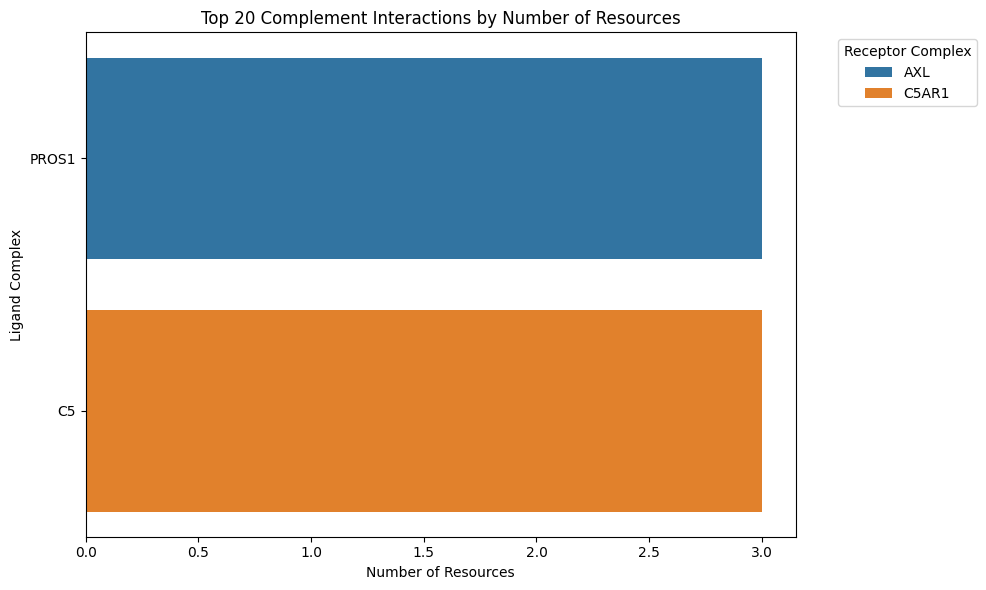

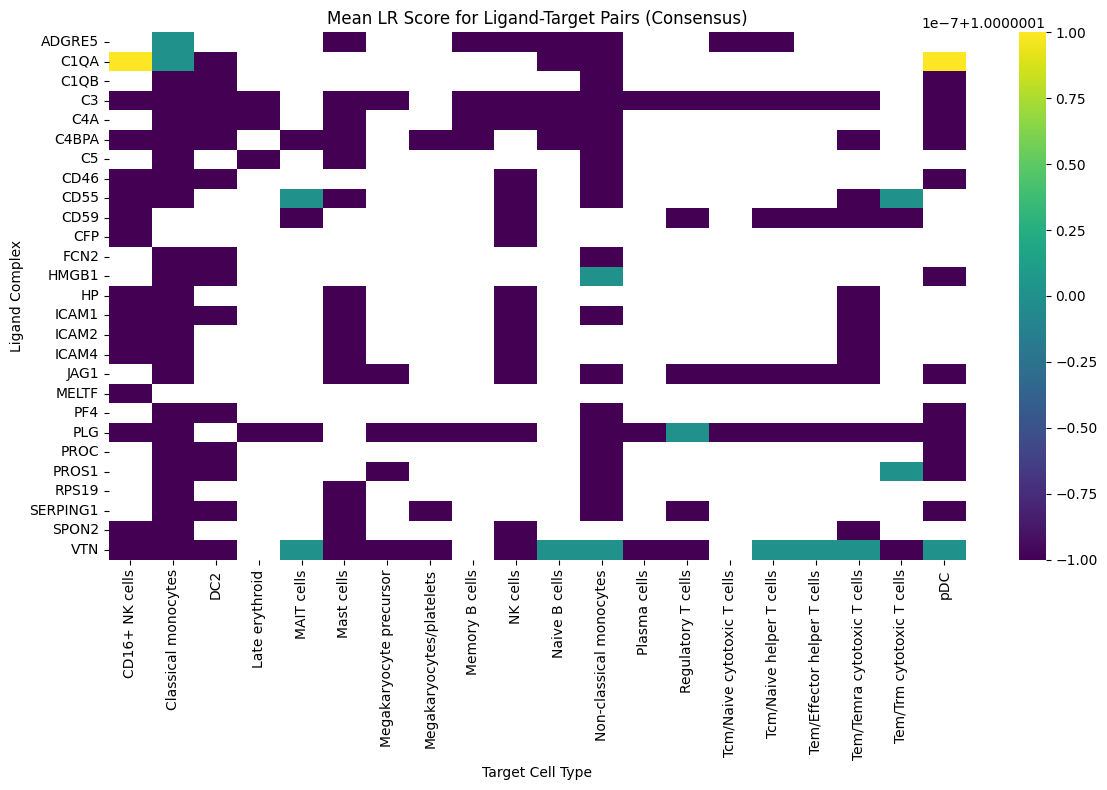

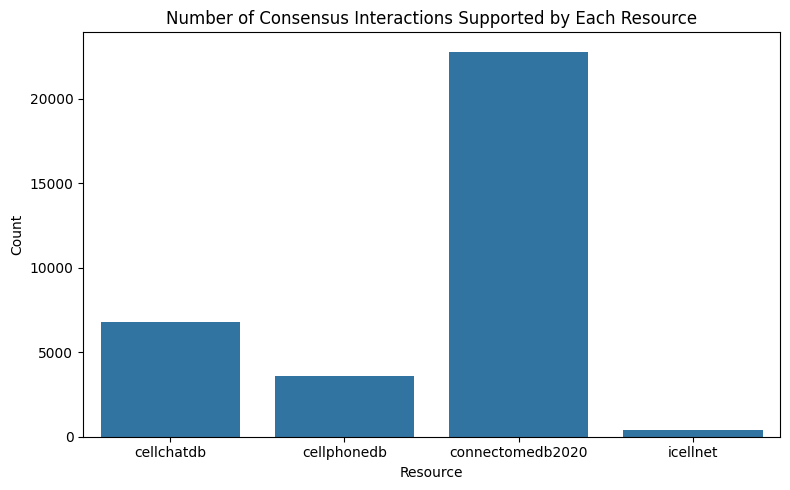

In [2]:
# Visualization of LIANA Results
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Load consensus table
df_consensus = pd.read_csv(os.path.join(OUTDIR, "consensus_complement_interactions.csv"))

# --- Plot 1: Top Interactions by Number of Resources ---
top_n = 20
plot_df = df_consensus.head(top_n)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    y="ligand_complex",
    x="n_resources",
    hue="receptor_complex",
    dodge=False
)
plt.title(f"Top {top_n} Complement Interactions by Number of Resources")
plt.xlabel("Number of Resources")
plt.ylabel("Ligand Complex")
plt.legend(title="Receptor Complex", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Plot 2: Heatmap of Mean LR Score (Ligand-Target Pairs) ---
heatmap_data = df_consensus.pivot_table(
    index="ligand_complex",
    columns="target",
    values="mean_lrscore",
    aggfunc="max"
)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="viridis", annot=False)
plt.title("Mean LR Score for Ligand-Target Pairs (Consensus)")
plt.xlabel("Target Cell Type")
plt.ylabel("Ligand Complex")
plt.tight_layout()
plt.show()

# --- Plot 3: Per-Resource Interaction Counts (Fixed) ---
def ensure_list(x):
    if isinstance(x, list):
        return x
    elif pd.isna(x):
        return []
    elif isinstance(x, str):
        # Try to parse string representation of list
        if x.startswith("[") and x.endswith("]"):
            import ast
            return ast.literal_eval(x)
        else:
            return [x]
    else:
        return [x]

df_consensus["resources"] = df_consensus["resources"].apply(ensure_list)

plt.figure(figsize=(8, 5))
sns.countplot(
    data=df_consensus.explode("resources"),
    x="resources",
    order=sorted(set(sum(df_consensus["resources"].tolist(), [])))
)
plt.title("Number of Consensus Interactions Supported by Each Resource")
plt.xlabel("Resource")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [3]:
# 1. Chord/Circos Plot of Cell–Cell Interactions
# Requires: plotly, pandas
import plotly.graph_objects as go
import numpy as np

# Prepare data: sum mean_lrscore for each source-target pair
cell_types = sorted(set(df_consensus['source']).union(df_consensus['target']))
mat = pd.pivot_table(df_consensus, index='source', columns='target', values='mean_lrscore', aggfunc='sum', fill_value=0)
mat = mat.reindex(index=cell_types, columns=cell_types, fill_value=0)

# Chord plot using plotly (simplified)
fig = go.Figure(data=[
    go.Heatmap(
        z=mat.values,
        x=mat.columns,
        y=mat.index,
        colorscale='Viridis',
        colorbar=dict(title='Sum Mean LR Score')
    )
])
fig.update_layout(title='Cell–Cell Communication: Sum Mean LR Score', xaxis_title='Target', yaxis_title='Source')
fig.show()

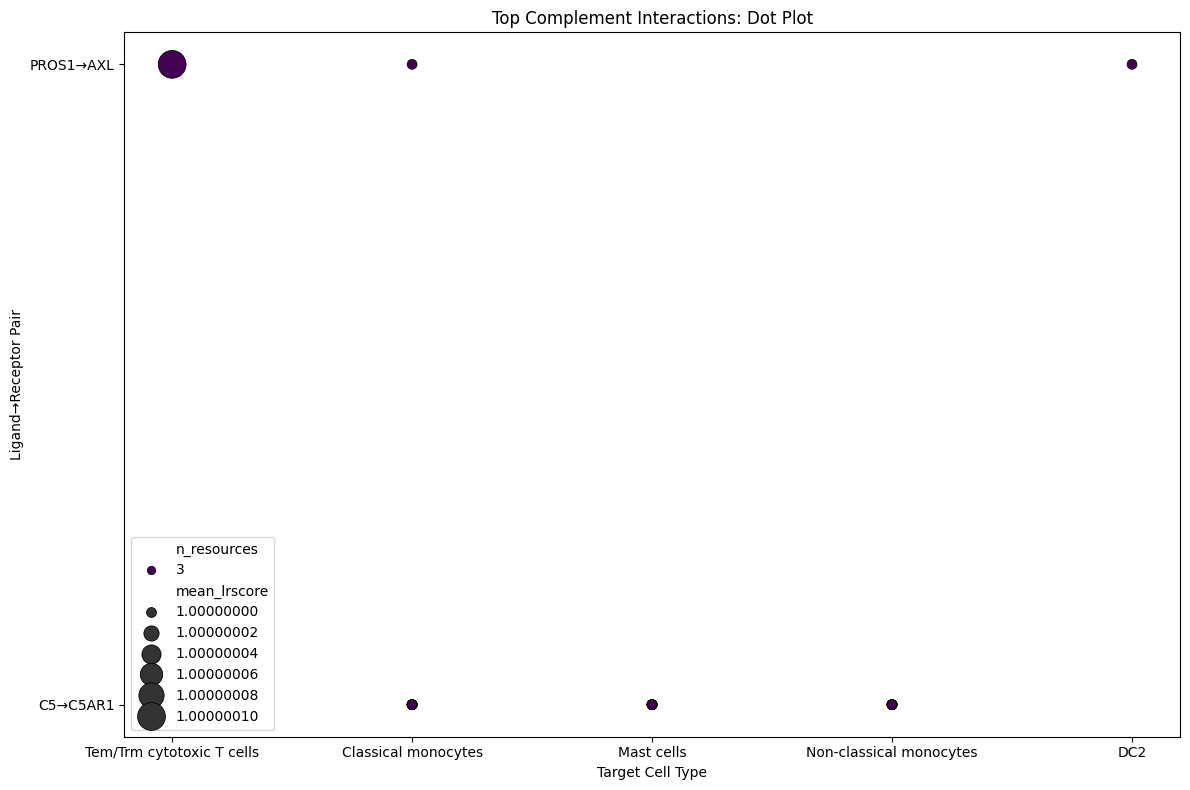

In [4]:
# 2. Dot Plot of Top Interactions
# X: target, Y: ligand–receptor, dot size: mean_lrscore, color: n_resources

top_n = 30
plot_df = df_consensus.head(top_n).copy()
plot_df['pair'] = plot_df['ligand_complex'] + '→' + plot_df['receptor_complex']
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_df,
    x='target',
    y='pair',
    size='mean_lrscore',
    hue='n_resources',
    palette='viridis',
    sizes=(50, 400),
    legend='brief',
    edgecolor='black'
)
plt.title('Top Complement Interactions: Dot Plot')
plt.xlabel('Target Cell Type')
plt.ylabel('Ligand→Receptor Pair')
plt.tight_layout()
plt.show()

StopIteration: 

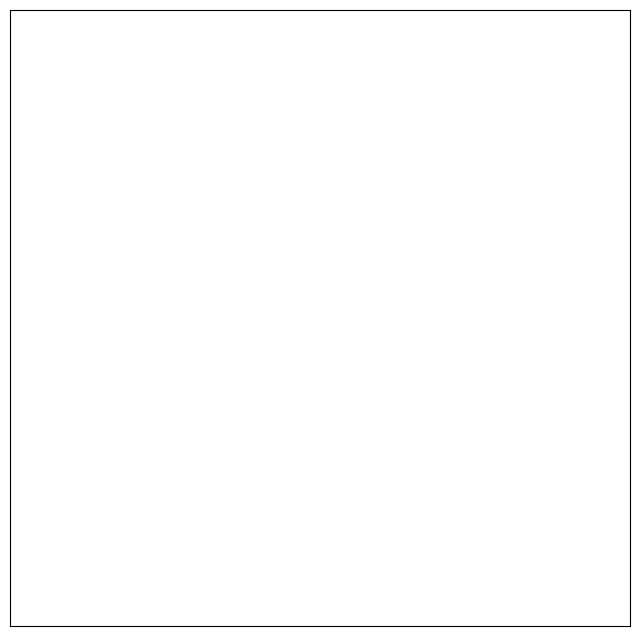

In [5]:
# 3. Network Graph of Cell–Cell Communication
# Requires: networkx, matplotlib
import networkx as nx

G = nx.DiGraph()
for _, row in df_consensus.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['mean_lrscore'])

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)
weights = [G[u][v]['weight'] for u, v in G.edges]
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, width=np.array(weights)*2, alpha=0.6, arrows=True)
plt.title('Cell–Cell Communication Network (Edge width = mean LR score)')
plt.axis('off')
plt.show()

/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/aumchampaneri/.py

<Figure size 800x500 with 0 Axes>

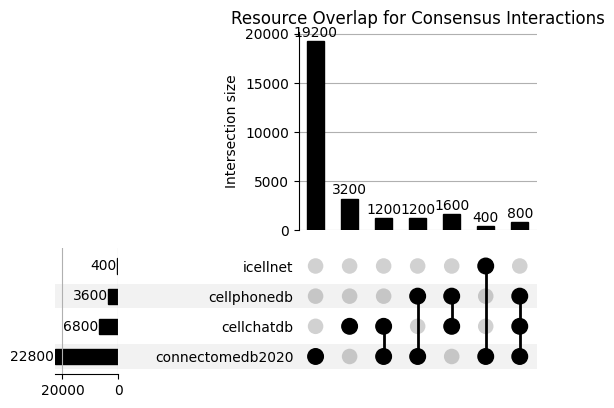

In [7]:
# 4. UpSet Plot for Resource Overlap
# Requires: upsetplot, matplotlib
from upsetplot import UpSet, from_memberships

# Build memberships for each interaction
memberships = [tuple(sorted(r)) for r in df_consensus['resources']]
upset_data = from_memberships(memberships)
plt.figure(figsize=(8, 5))
UpSet(upset_data, subset_size='count', show_counts=True).plot()
plt.title('Resource Overlap for Consensus Interactions')
plt.show()

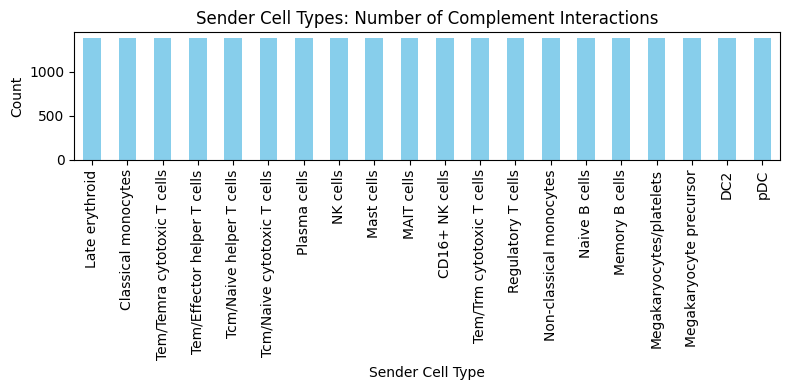

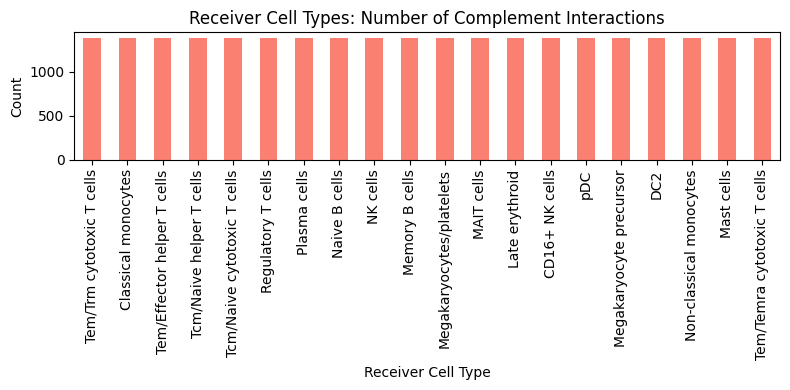

In [8]:
# 6. Sender/Receiver Cell Type Barplots
# Barplots of most frequent senders and receivers in complement interactions

sender_counts = df_consensus['source'].value_counts()
receiver_counts = df_consensus['target'].value_counts()

plt.figure(figsize=(8, 4))
sender_counts.plot(kind='bar', color='skyblue')
plt.title('Sender Cell Types: Number of Complement Interactions')
plt.xlabel('Sender Cell Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
receiver_counts.plot(kind='bar', color='salmon')
plt.title('Receiver Cell Types: Number of Complement Interactions')
plt.xlabel('Receiver Cell Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

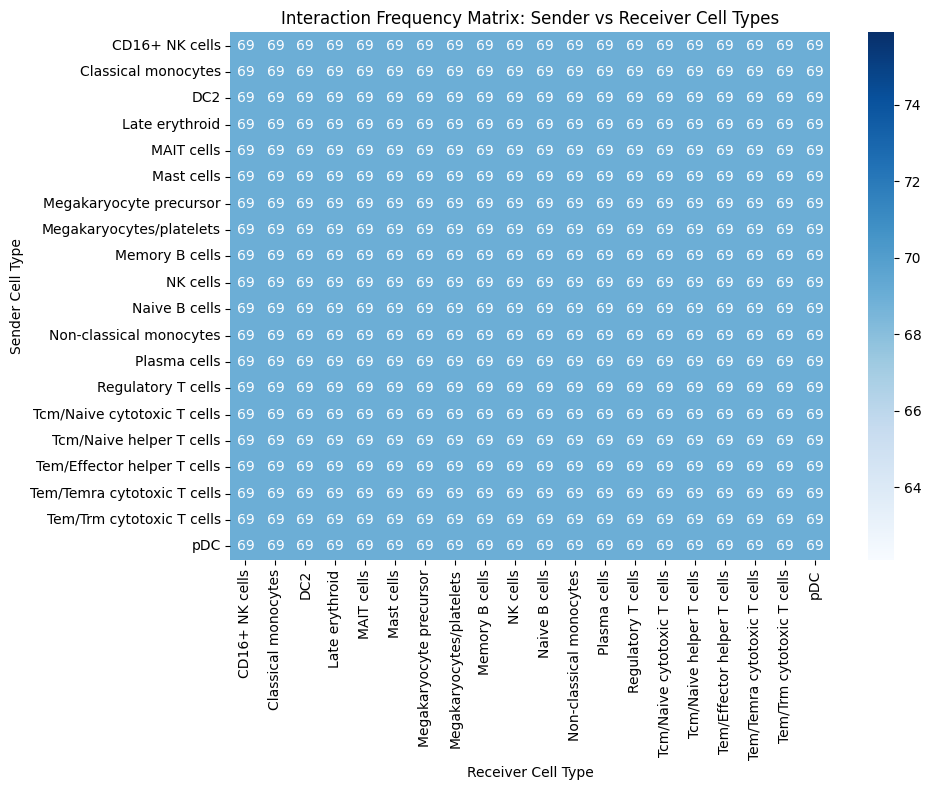

In [9]:
# 8. Interaction Frequency Matrix (fixed)
# Matrix plot showing frequency of interactions between sender and receiver cell types
freq_matrix = pd.pivot_table(
    df_consensus,
    index='source',
    columns='target',
    aggfunc='size',
    fill_value=0
)
plt.figure(figsize=(10, 8))
sns.heatmap(freq_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Interaction Frequency Matrix: Sender vs Receiver Cell Types')
plt.xlabel('Receiver Cell Type')
plt.ylabel('Sender Cell Type')
plt.tight_layout()
plt.show()

# Probabilistic modeling and analysis of single-cell omics data in rare disease

This section demonstrates how to use the scVI model and embeddings to analyze a rare disease dataset, following the workflow from the vcp-tutorial-scvi notebook.

## Environment Setup and Imports

Install and import required packages for scVI, CELLxGENE Census, and single-cell analysis.

In [ ]:
# Install required packages (uncomment if running in a new environment)
# !pip install scvi-tools==1.2.0 tiledbsoma==1.14.4 'cellxgene_census[experimental]'==1.16.2 scanpy==1.10.3 jupyterlab jupyter ipywidgets

import os, sys, gc, warnings, pprint, yaml, json, functools
warnings.filterwarnings('ignore')

import cellxgene_census
from cellxgene_census.experimental import get_embedding
import tiledbsoma as soma
import scvi
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
import matplotlib.pylab as plt

CENSUS_VERSION = "2024-07-01"
pp = pprint.PrettyPrinter(indent=4)
%matplotlib inline

## Load AnnData object

In [ ]:
adata = sc.read_h5ad(f"{PDIR}/sjogrens-pbmc/input-data/sjogrens-pbmc_prepared.h5ad")

## Download and Prepare scVI Model

Download the pretrained scVI model and align your data's feature space.

In [ ]:
!mkdir -p ../sjogrens-pbmc/scvi-human-2024-07-01
!curl -L -o ../sjogrens-pbmc/scvi-human-2024-07-01/model.pt https://cellxgene-contrib-public.s3.us-west-2.amazonaws.com/models/scvi/2024-07-01/homo_sapiens/model.pt

In [ ]:
# Prepare AnnData for scVI
scvi.model.SCVI.prepare_query_anndata(adata,
                                      "../sjogrens-pbmc/scvi-human-2024-07-01",
                                      return_reference_var_names=True)
adata.var.head()

## Generate Embeddings and Visualize

Run the model to generate embeddings and visualize using UMAP.

In [ ]:
# Set var index to Ensembl IDs for scVI compatibility
adata.var.set_index("ensembl_id", inplace=True)

In [ ]:
# Align and run model inference
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.neighbors(adata, n_neighbors=20, use_rep="scvi")
umap_scvi = sc.tl.umap(adata, copy=True, n_components=2)
adata.obsm['X_umap_scvi'] = umap_scvi.obsm['X_umap']
sc.pl.umap(umap_scvi, color=["disease", "cell_batch", "join_id"])

## Search for Similar Cells in CELLxGENE Census

Use the scVI embeddings to find similar cells in the CELLxGENE corpus.

In [ ]:
# Find similar cells in CELLxGENE Census
neighbors = cellxgene_census.experimental.find_nearest_obs(
    "scvi", "homo_sapiens", CENSUS_VERSION, query=adata, k=10, memory_GiB=24, nprobe=20
)
neighbors

## Retrieve and Visualize Reference Data

Download and visualize metadata and embeddings for the identified similar cells.

In [ ]:
# Download reference AnnData for similar cells
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    neighbors_adata = cellxgene_census.get_anndata(
        census,
        "homo_sapiens",
        "RNA",
        obs_coords=sorted(neighbors.neighbor_ids[:, 0].tolist()),
        obs_embeddings=["scvi"],
        X_name="normalized",
        column_names={"obs": ["soma_joinid", "tissue", "tissue_general", "cell_type", "disease", "dataset_id"]},
    )
neighbors_adata.var_names = neighbors_adata.var["feature_id"]

# Visualize UMAP of reference data
sc.pp.neighbors(neighbors_adata, n_neighbors=10, use_rep="scvi")
neighbors_adata = sc.tl.umap(neighbors_adata, copy=True, n_components=2)
neighbors_adata.obs["cell_type"] = neighbors_adata.obs["cell_type"].cat.remove_unused_categories()
neighbors_adata.obs["tissue"] = neighbors_adata.obs["tissue"].cat.remove_unused_categories()
neighbors_adata.obs["tissue"] = neighbors_adata.obs["tissue_general"].cat.remove_unused_categories()
sc.pl.umap(neighbors_adata, color="tissue_general")
print(neighbors_adata.obs['tissue'].value_counts())
print(neighbors_adata.obs['cell_type'].value_counts())
print(neighbors_adata.obs['dataset_id'].value_counts())